# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

In [4]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif

from gaussian_model import create_and_draw_best_gaussian_mix
from gaussian_model import create_gaussian_model


from draw_and_create_clusters import display_circles

from create_prediction import create_prediction
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals

from print_examples import plot_difference, create_example_df, find_most_different, show_real_share
from create_target_columns import create_target_columns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100

list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']
included_col_start = 'Ääniosuus'
all_included_columns = create_target_columns(list_of_parties, included_col_start)
included_col_start = 'Äänet yhteensä lkm'
all_included_columns_2 = create_target_columns(list_of_parties, included_col_start)
share_of_votes = 'Ääniosuus'
total_votes = 'Äänet yhteensä lkm Äänioikeutetut yhteensä'



n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0
covariance_type = 'full'

filename_model_aic = 'aic_cluster'
filename_model_bic = 'bic_cluster'

data, X, test, gmm_bic, gmm_aic = create_and_draw_best_gaussian_mix(filename_model_aic, filename_model_bic, path, stat, stat, numeric_features=numeric_features, categorical_features=categorical_features, scaled=scaled, covariance_type = covariance_type)
data = create_gaussian_model(data, X, gmm_bic)

print(data['cluster'].value_counts())


load model
Silhouette Coefficient: 0.101 Calinski Harabaz Index: 242
2    1059
3    1033
0     491
4     236
1     151
Name: cluster, dtype: int64


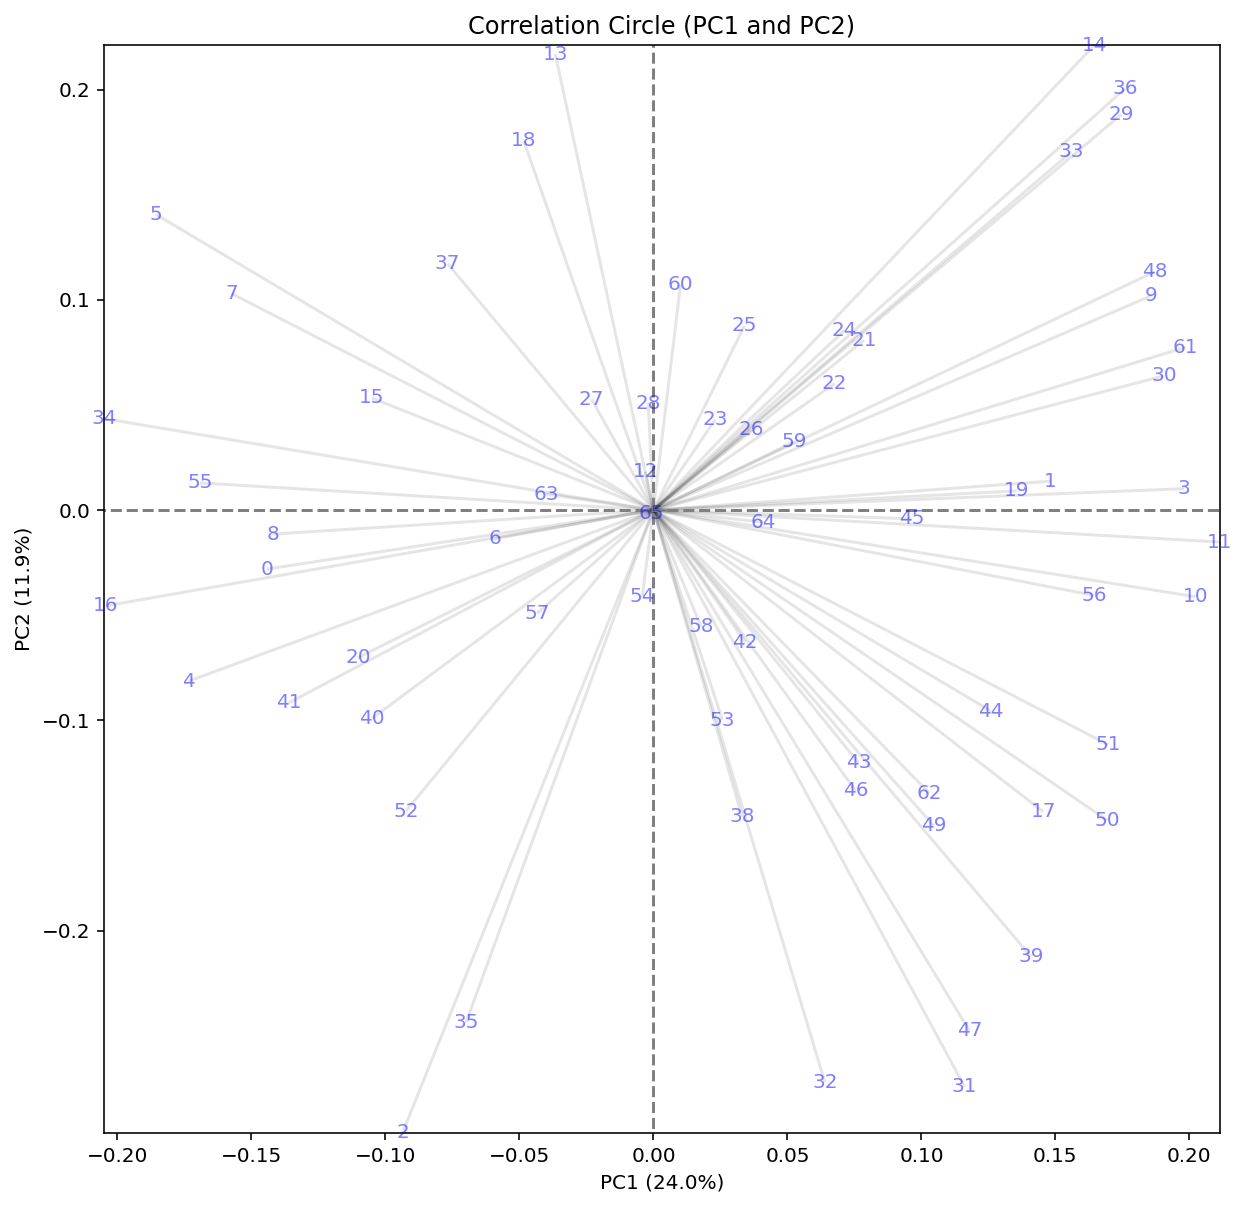

In [5]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [6]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

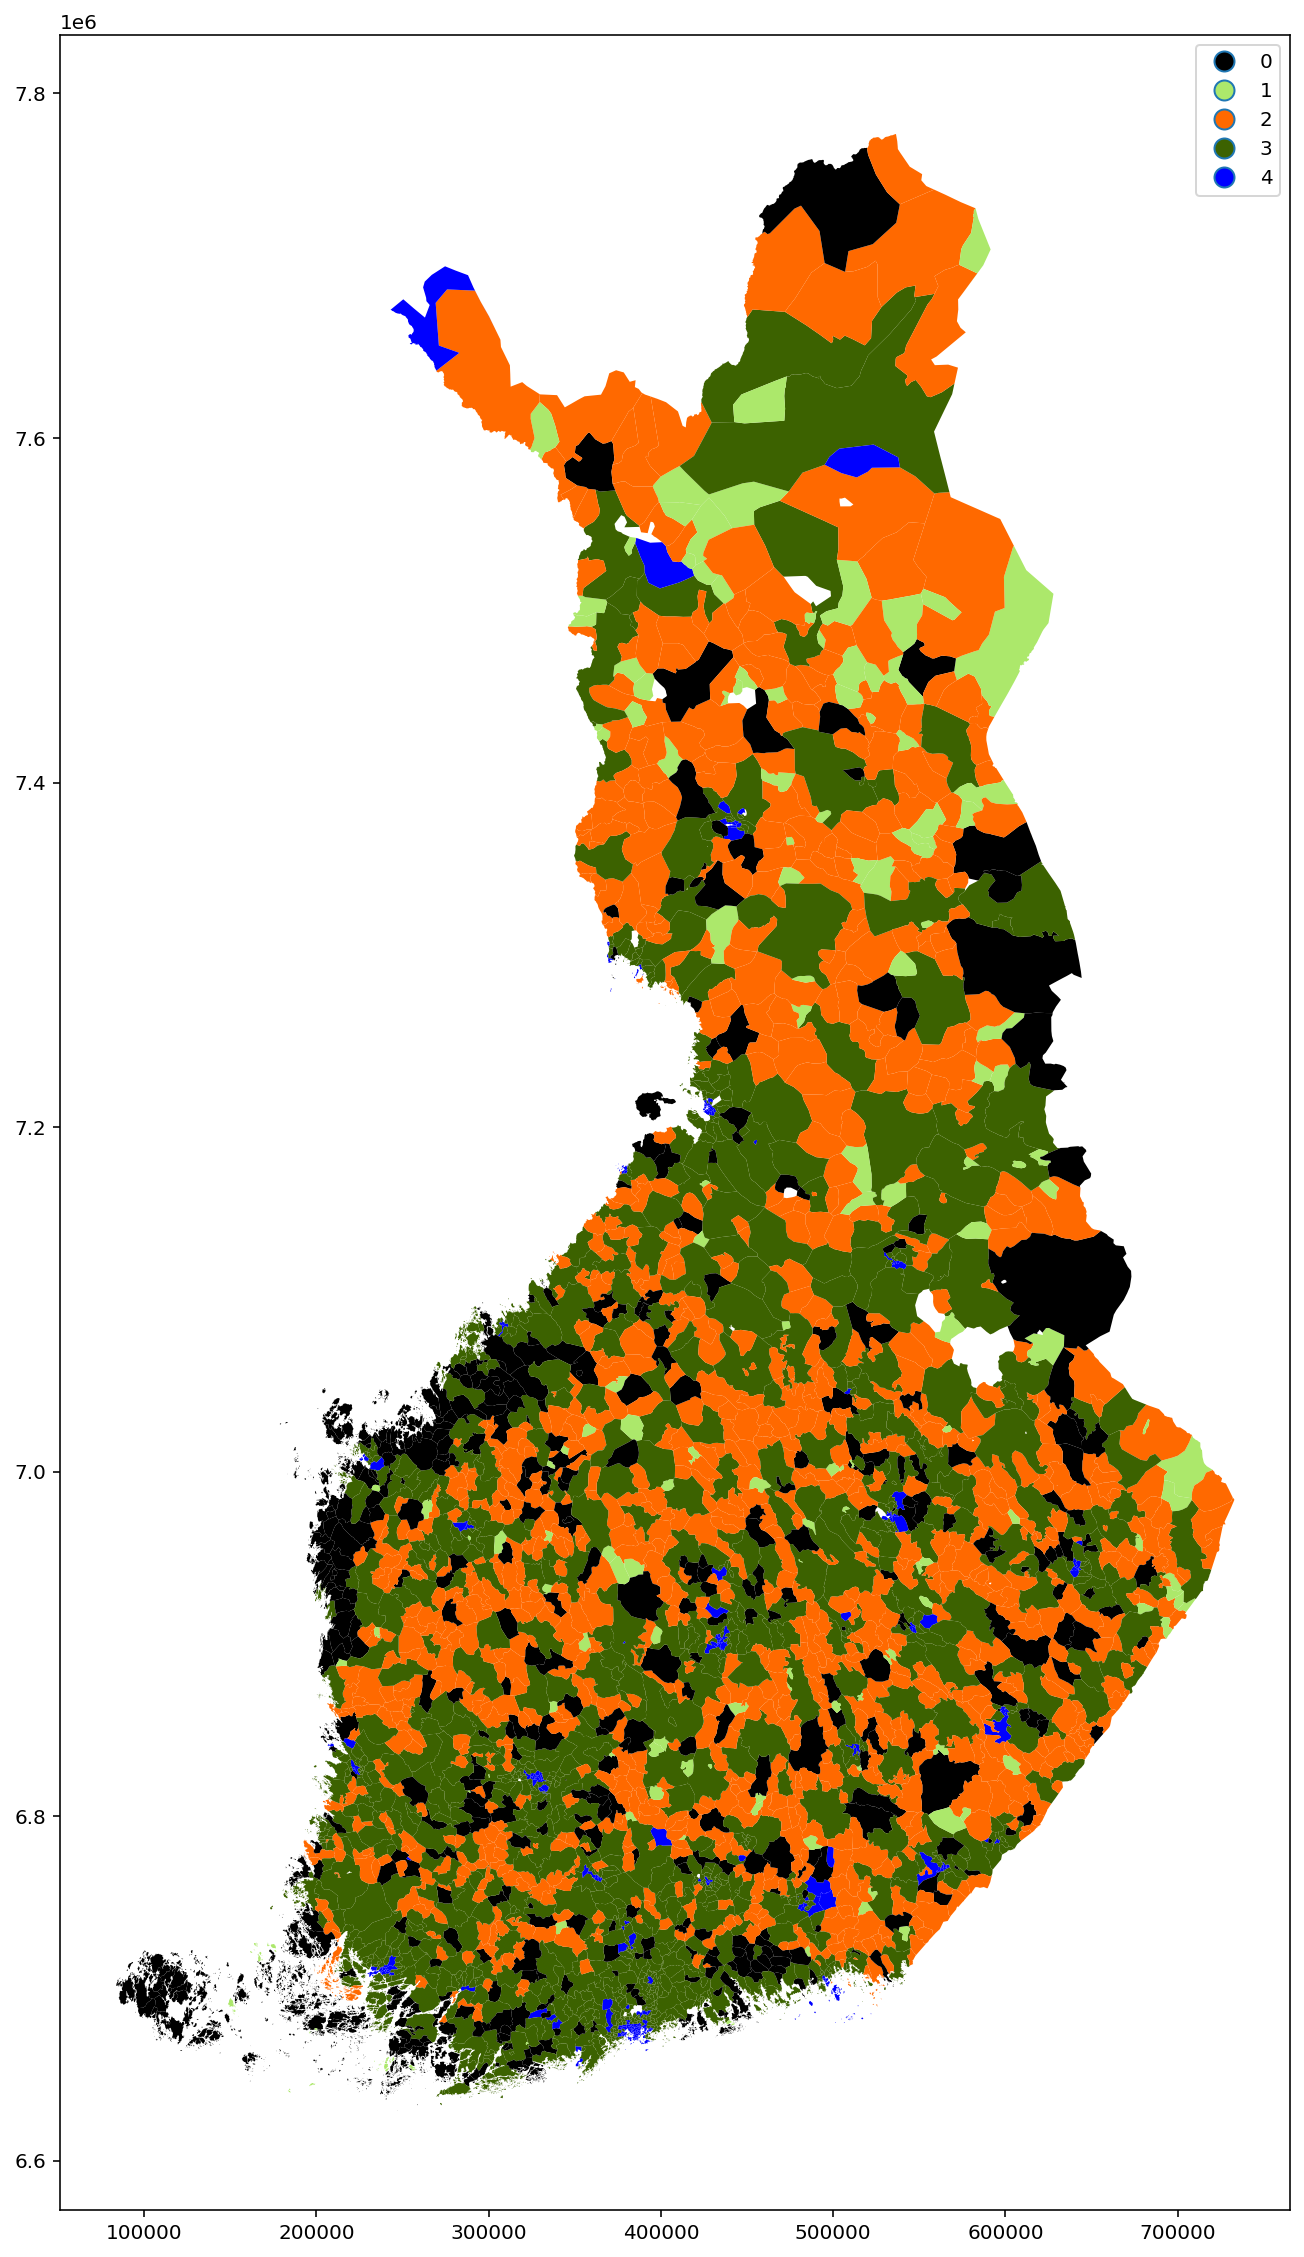

In [7]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [8]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'gauss_xgboost_cluster'

data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


load model


In [9]:
filename_model = 'gauss_mymodel_xgboost_cluster'
filename_shap =  'gauss_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


load model
load shap files


In [10]:
data[data['cluster']==1][features_df['Column'].head(5).to_list()].describe()

Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                       151.000000   
mean                                                          0.006181   
std                                                           0.075954   
min                                                           0.000000   
25%                                                           0.000000   
50%                                                           0.000000   
75%                                                           0.000000   
max                                                           0.933333   

       Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                            151.0   
mean                                                               0.0   
std                                                                0.0   
min                                                                0.0   
25%                                                                0.0   
50%                                                                0.0   
75%                                                                0.0   
max                                                                0.0   

       11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
count                                                                 151.000000   
mean                                                                    0.100045   
std                                                                     0.150265   
min                                                                     0.000000   
25%                                                                     0.000000   
50%                                                                     0.000000   
75%                                                                     0.214986   
max                                                                     0.595745   

       4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
count                                                                           151.0   
mean                                                                              0.0   
std                                                                               0.0   
min                                                                               0.0   
25%                                                                               0.0   
50%                                                                               0.0   
75%                                                                               0.0   
max                                                                               0.0   

       4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  
count                                                                                151.0  
mean                                                                                   0.0  
std                                                                                    0.0  
min                                                                                    0.0  
25%                                                                                    0.0  
50%                                                                                    0.0  
75%                                                                                    0.0  
max                                                                                    0.0

In [11]:
importance_df[importance_df['Importance type']==importance_df['Importance type'].unique()[1]].head(15)

Feature  \
66                   4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut   
67                            Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
68              4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut   
69                                                                                    Ääniosuus RKP   
70                                                  4.1.C Autoetu Yhteensä Summa, euroa osuus total   
71                                    K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat   
72                                                                        Category__language_code_1   
73                                                  Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat   
74                                  Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet   
75                                      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet   
76                                  Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet   
77                                                         P Koulutus, 2017 (TP) osuudesta asukkaat   
78                        11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut   
79                                      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total   
80  O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat   

          Score Importance type  
66  4543.371963      total_gain  
67  1867.940870      total_gain  
68   953.545304      total_gain  
69   773.575474      total_gain  
70   735.336581      total_gain  
71   719.444378      total_gain  
72   692.189229      total_gain  
73   683.500864      total_gain  
74   618.199796      total_gain  
75   577.613723      total_gain  
76   392.505594      total_gain  
77   328.475682      total_gain  
78   306.928539      total_gain  
79   276.443523      total_gain  
80   243.056140      total_gain

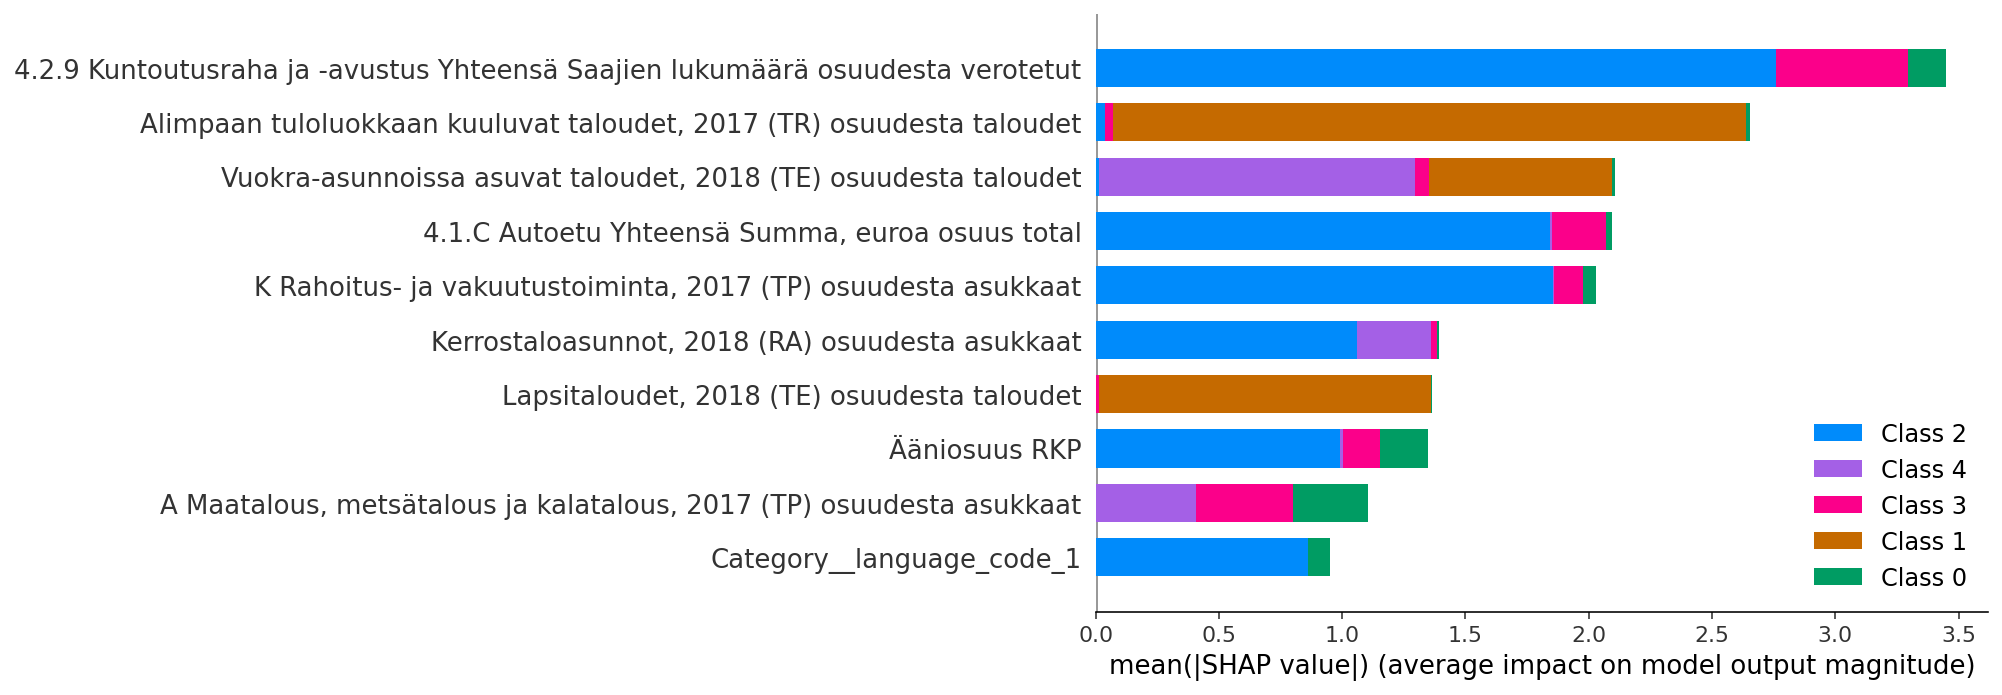

In [12]:
shap.summary_plot(shap_values, X,  max_display=10)

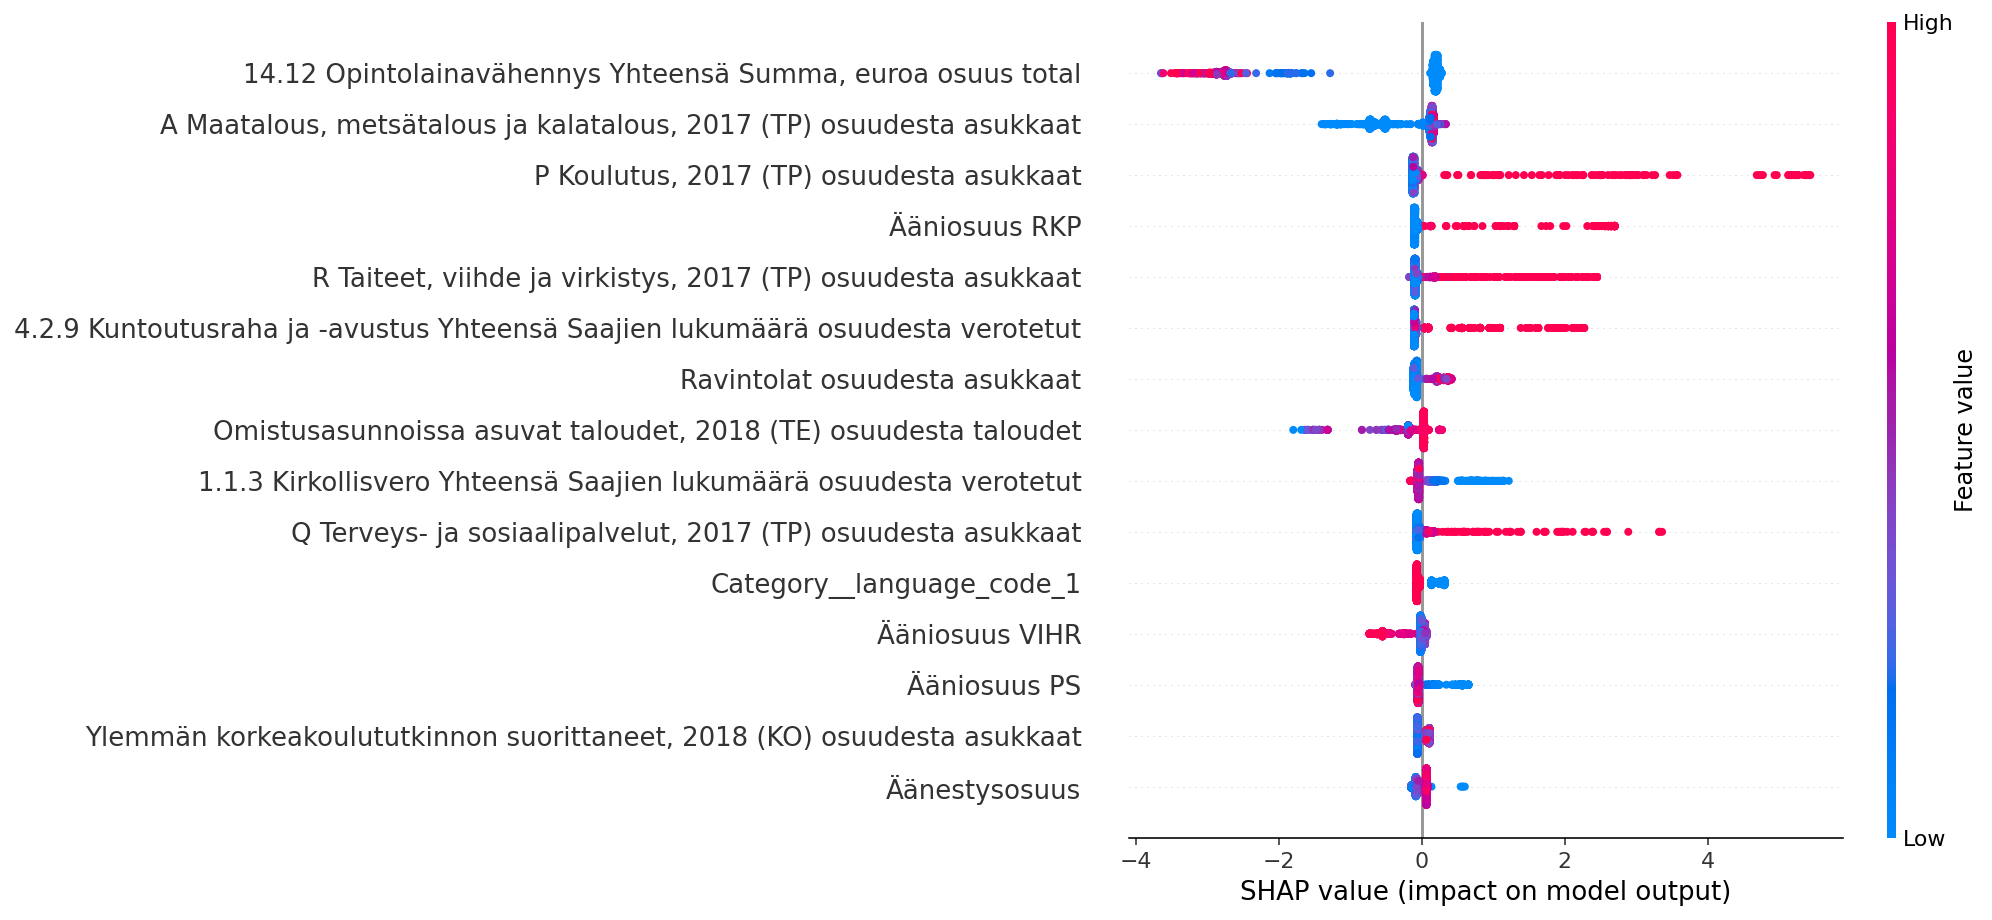

In [13]:
shap_index = 0
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
included_columns = []
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


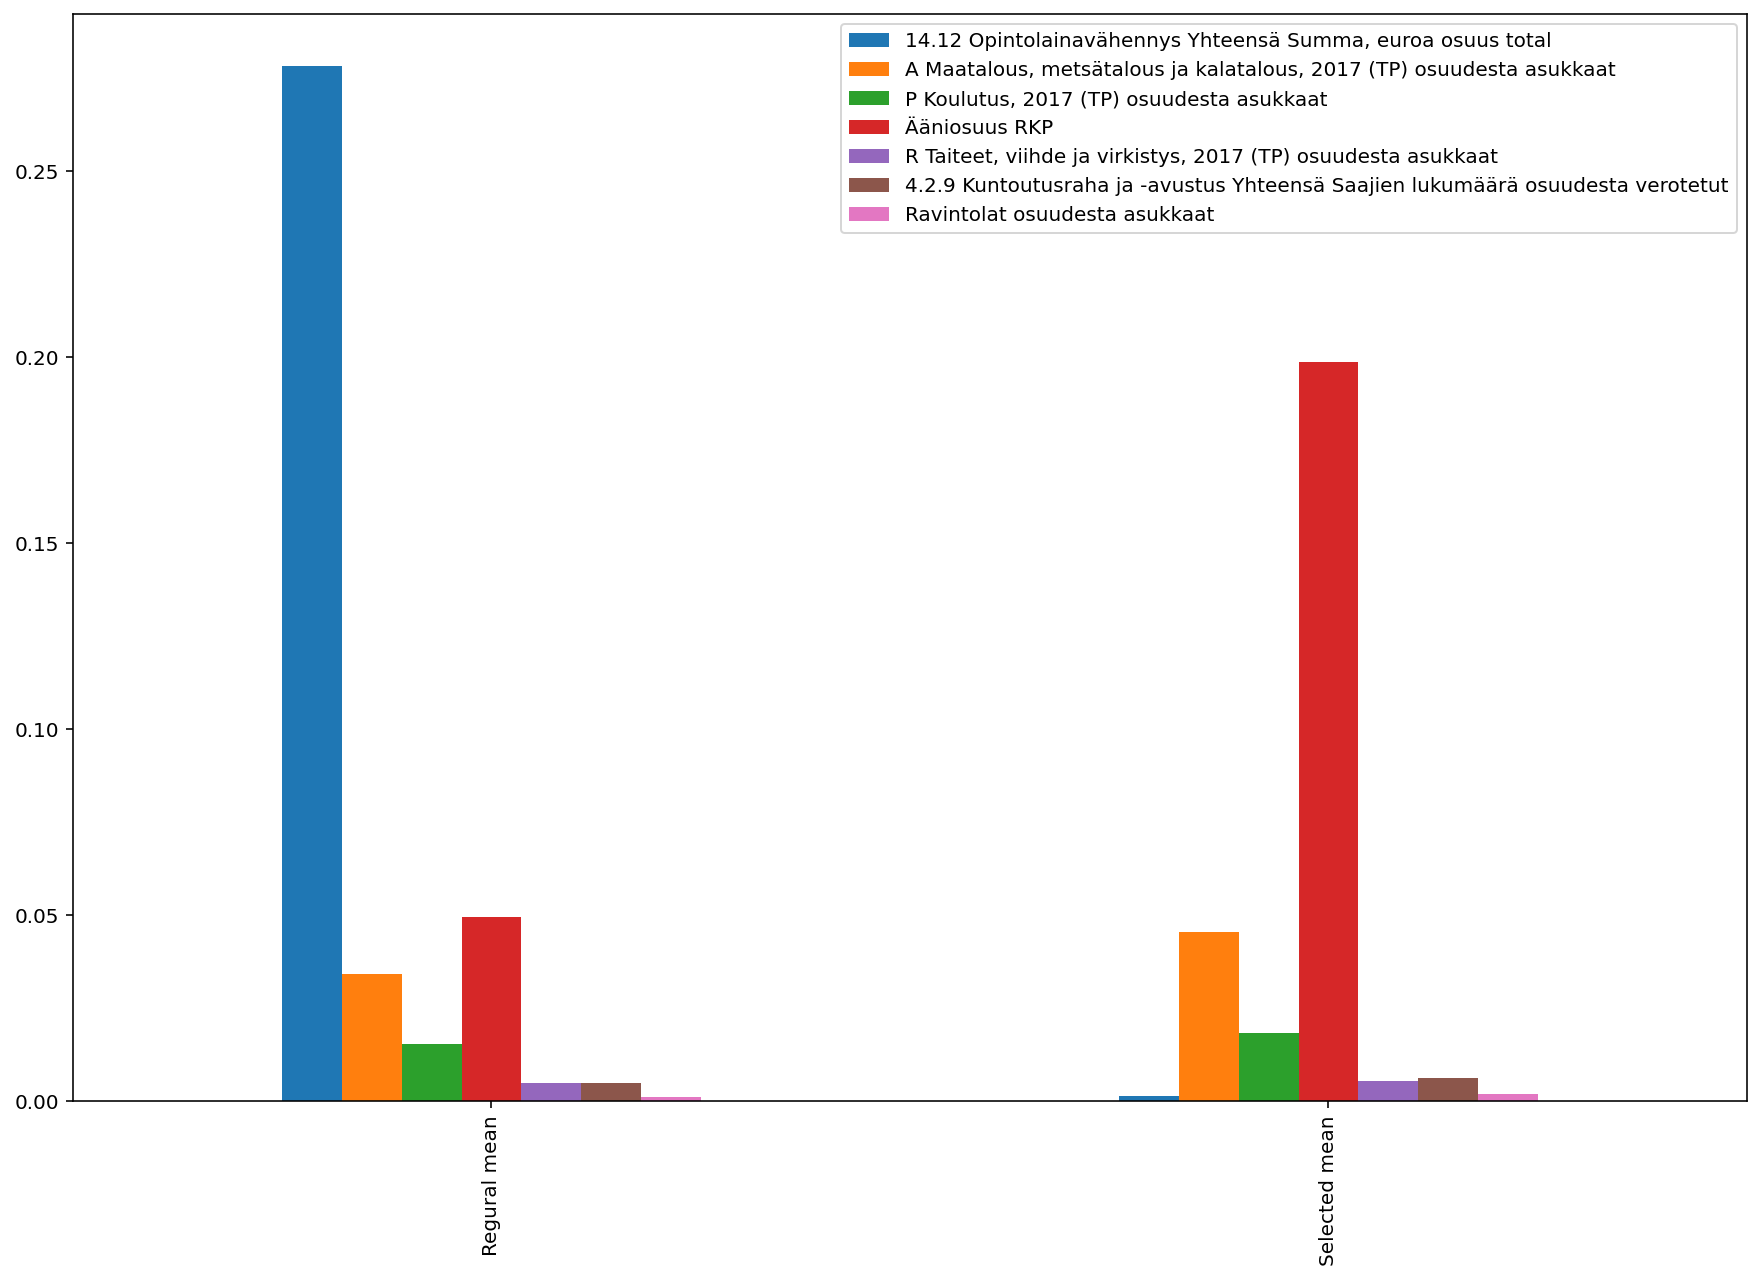

In [14]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

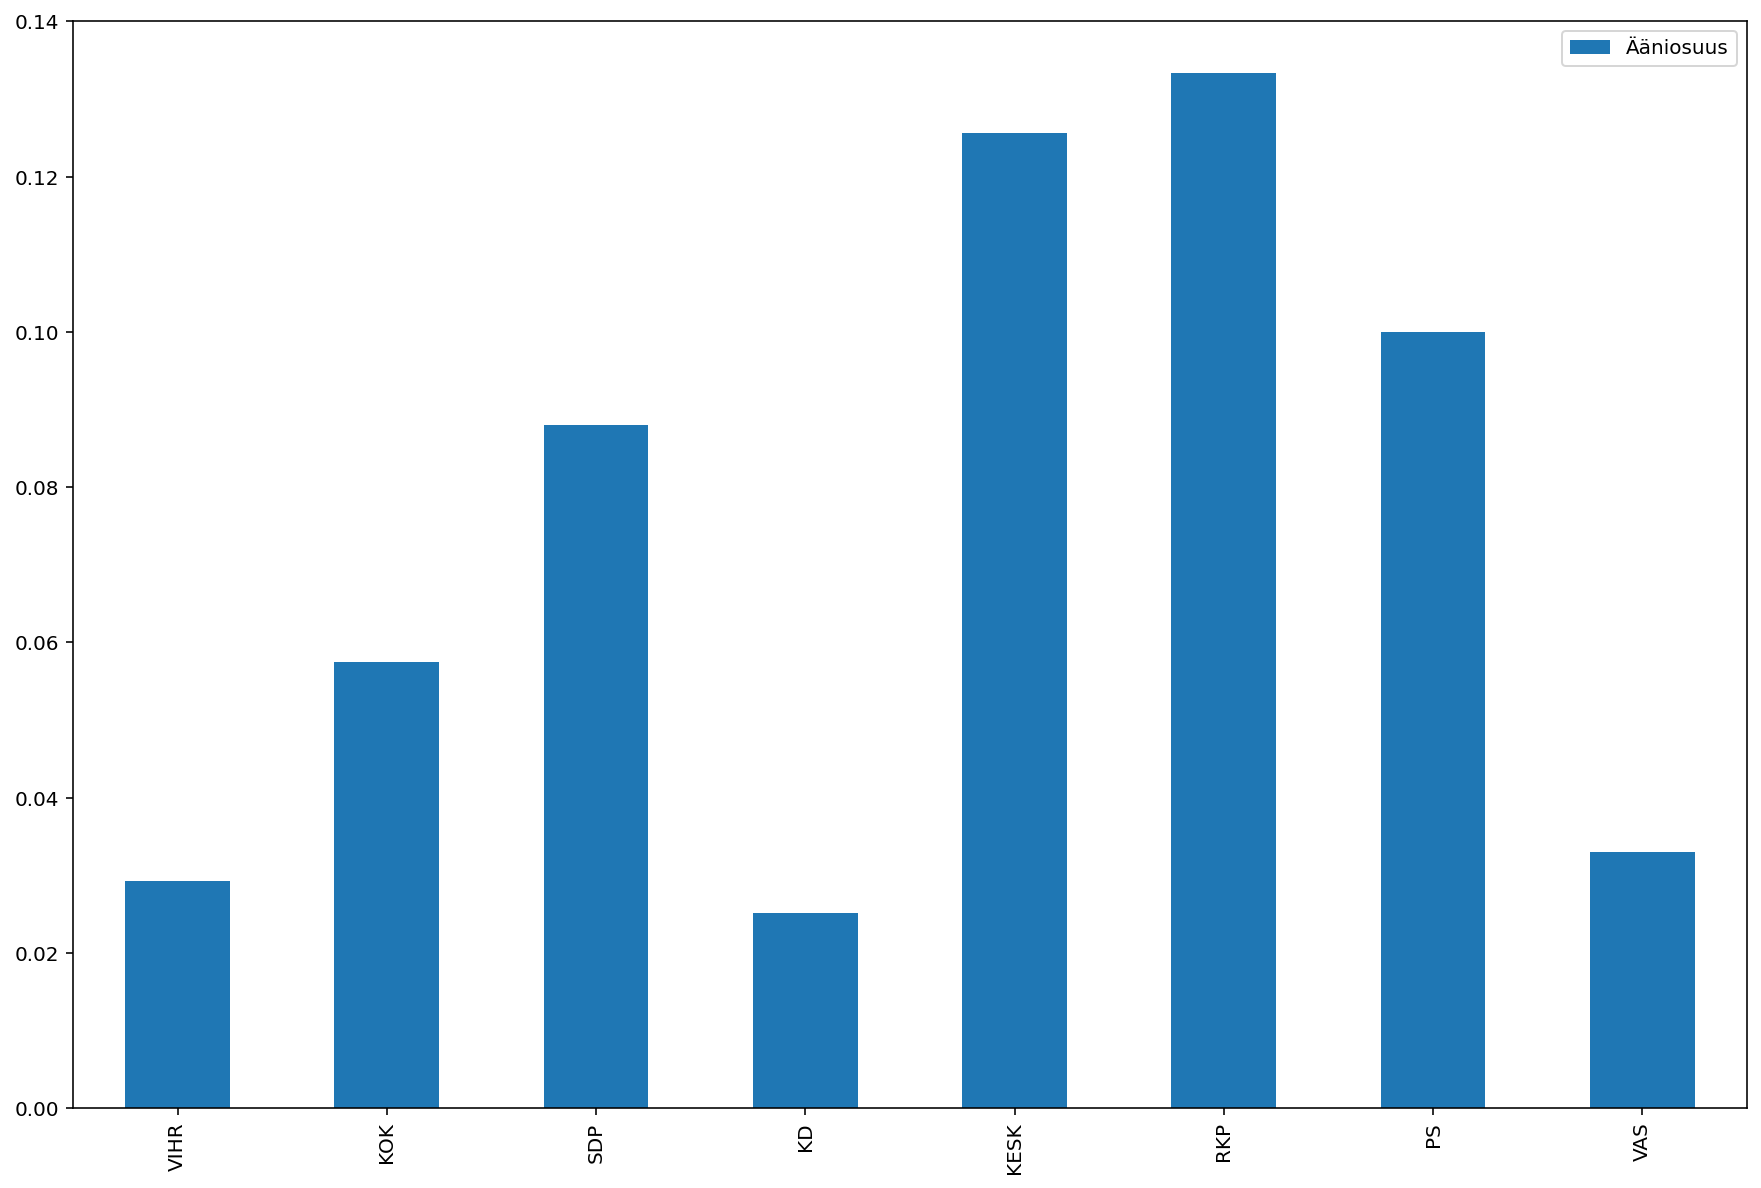

In [15]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [16]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2360       83430        KÄSÄMÄ           Liperi                         541.0   
1842       62710      KUREJOKI         Alajärvi                         768.0   
2450       85340         SIEVI            Sievi                         742.0   
2943       98800     SAVUKOSKI        Savukoski                         521.0   
2800       96700     ROVANIEMI        Rovaniemi                         753.0   

     Suurin_puolue  \
2360          KESK   
1842          KESK   
2450          KESK   
2943          KESK   
2800          KESK   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
2360                                                              0.012939   
1842                                                              0.027344   
2450                                                              0.033693   
2943                                                              0.147793   
2800                                                              0.007968   

      P Koulutus, 2017 (TP) osuudesta asukkaat  \
2360                                  0.153420   
1842                                  0.050781   
2450                                  0.018868   
2943                                  0.038388   
2800                                  0.009296   

      R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta asukkaat  \
2360                                                      0.000000   
1842                                                      0.000000   
2450                                                      0.000000   
2943                                                      0.001919   
2800                                                      0.001328   

      Ravintolat osuudesta asukkaat  \
2360                       0.001848   
1842                       0.000000   
2450                       0.000000   
2943                       0.007678   
2800                       0.000000   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2360                                                                        0.017505   
1842                                                                        0.009245   
2450                                                                        0.010893   
2943                                                                        0.000000   
2800                                                                        0.000000   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
2360                                                          0.0   
1842                                                          0.0   
2450                                                          0.0   
2943                                                          0.0   
2800                                                          0.0   

      Ääniosuus RKP  
2360            0.0  
1842            0.0  
2450            0.0  
2943            0.0  
2800            0.0

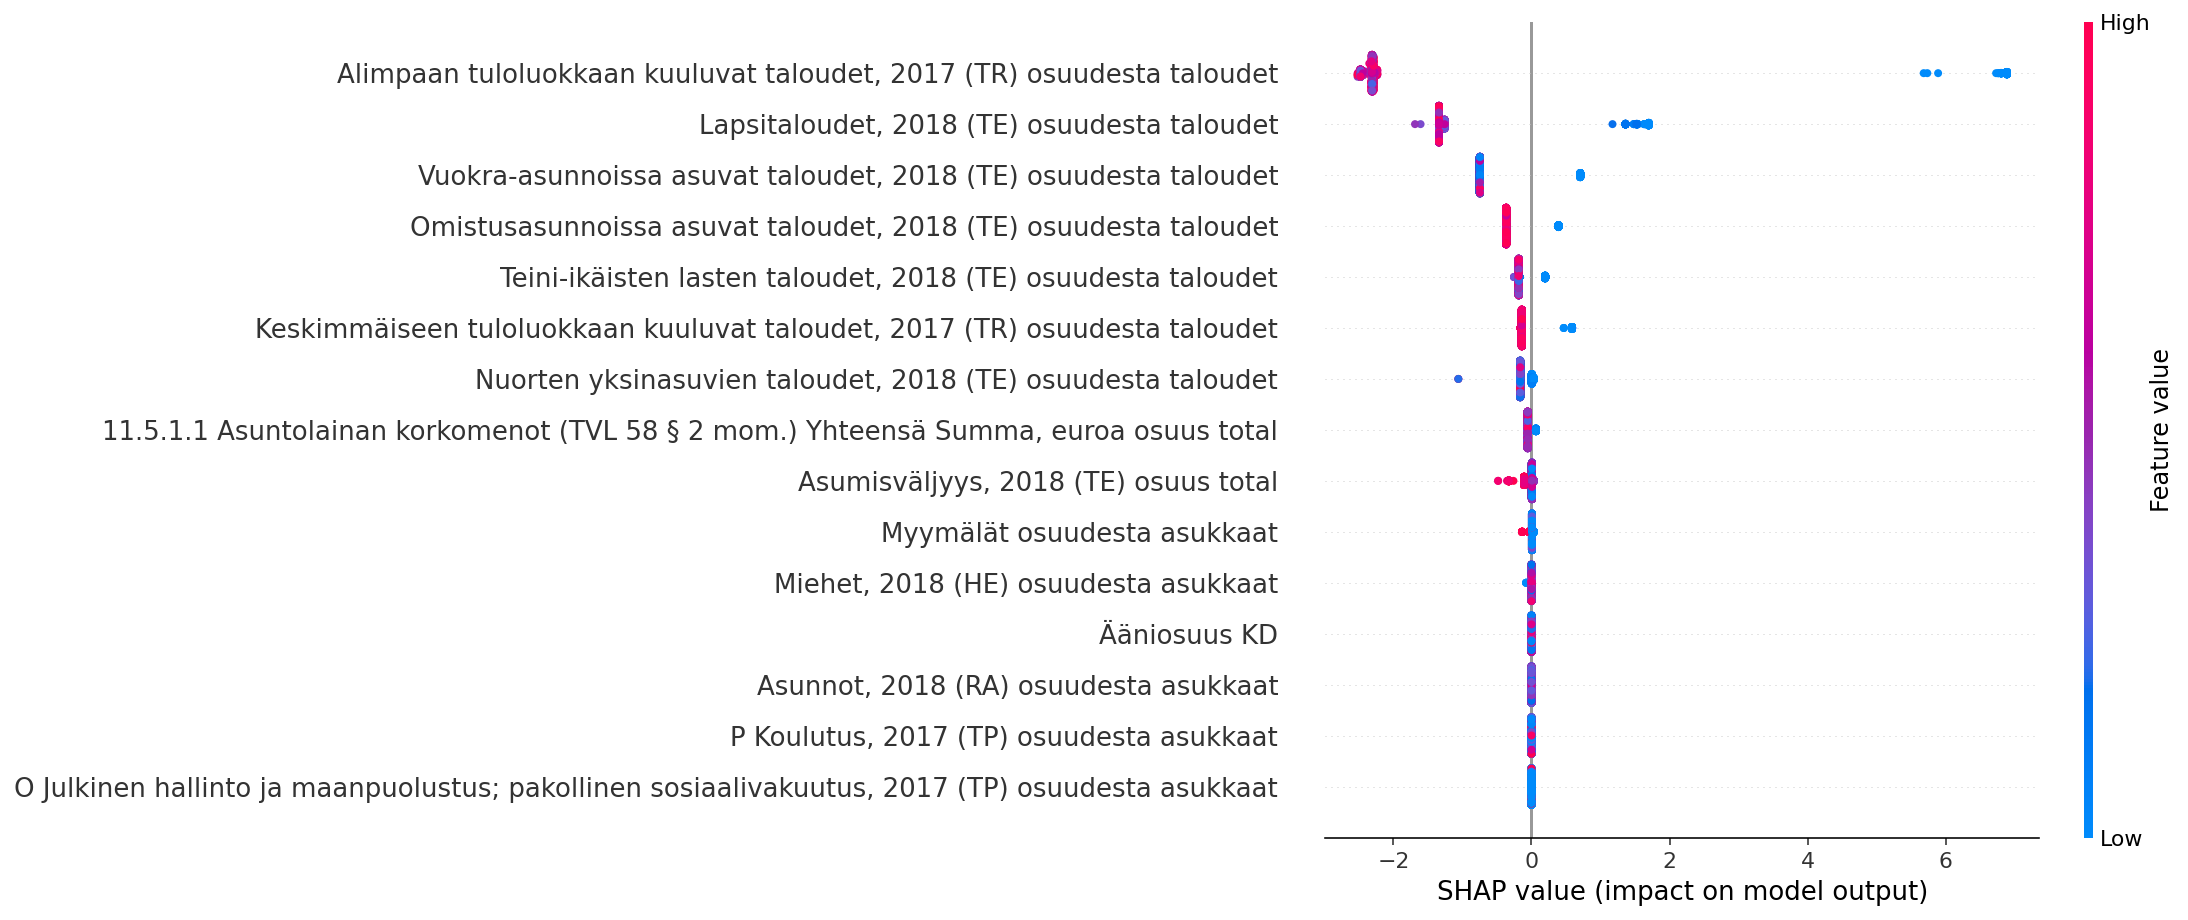

In [17]:
shap_index = 1
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


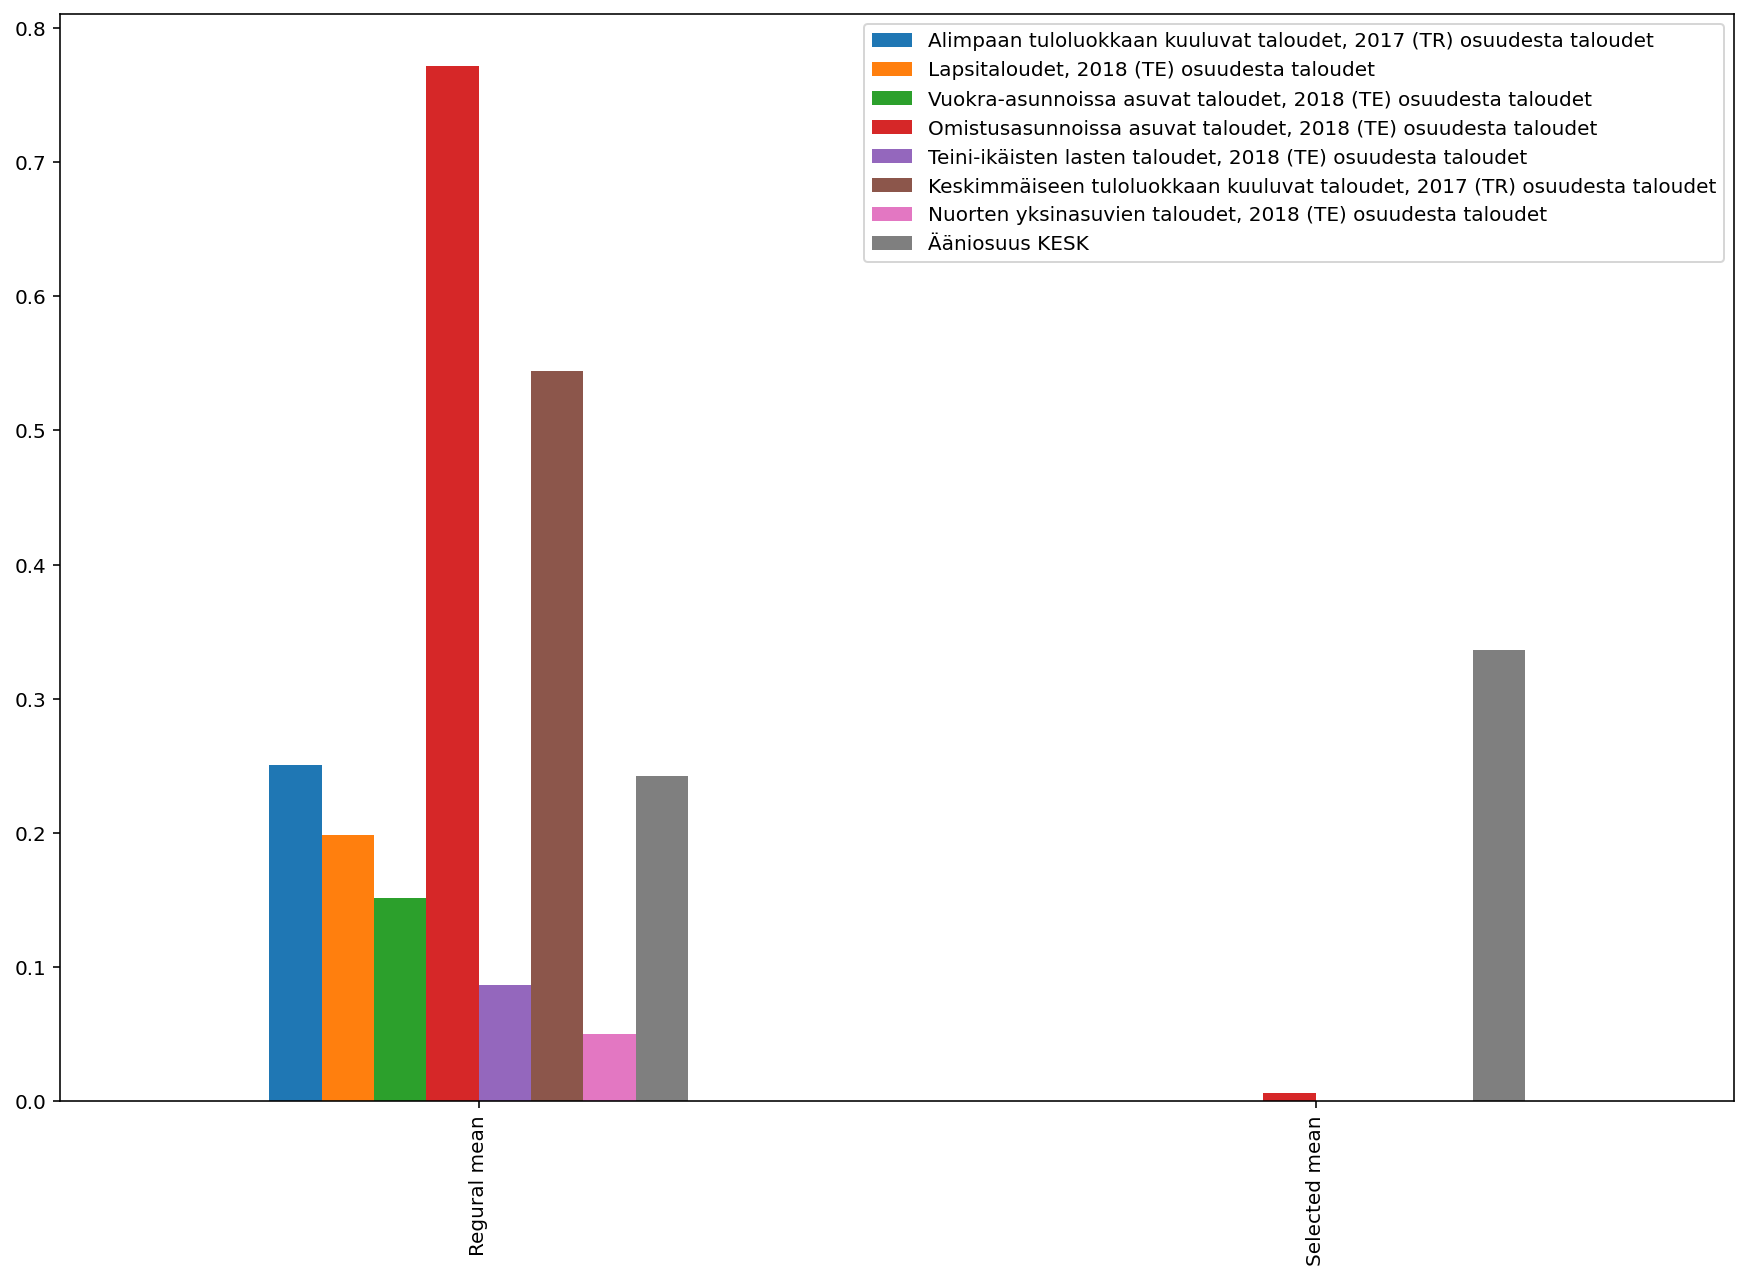

In [18]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

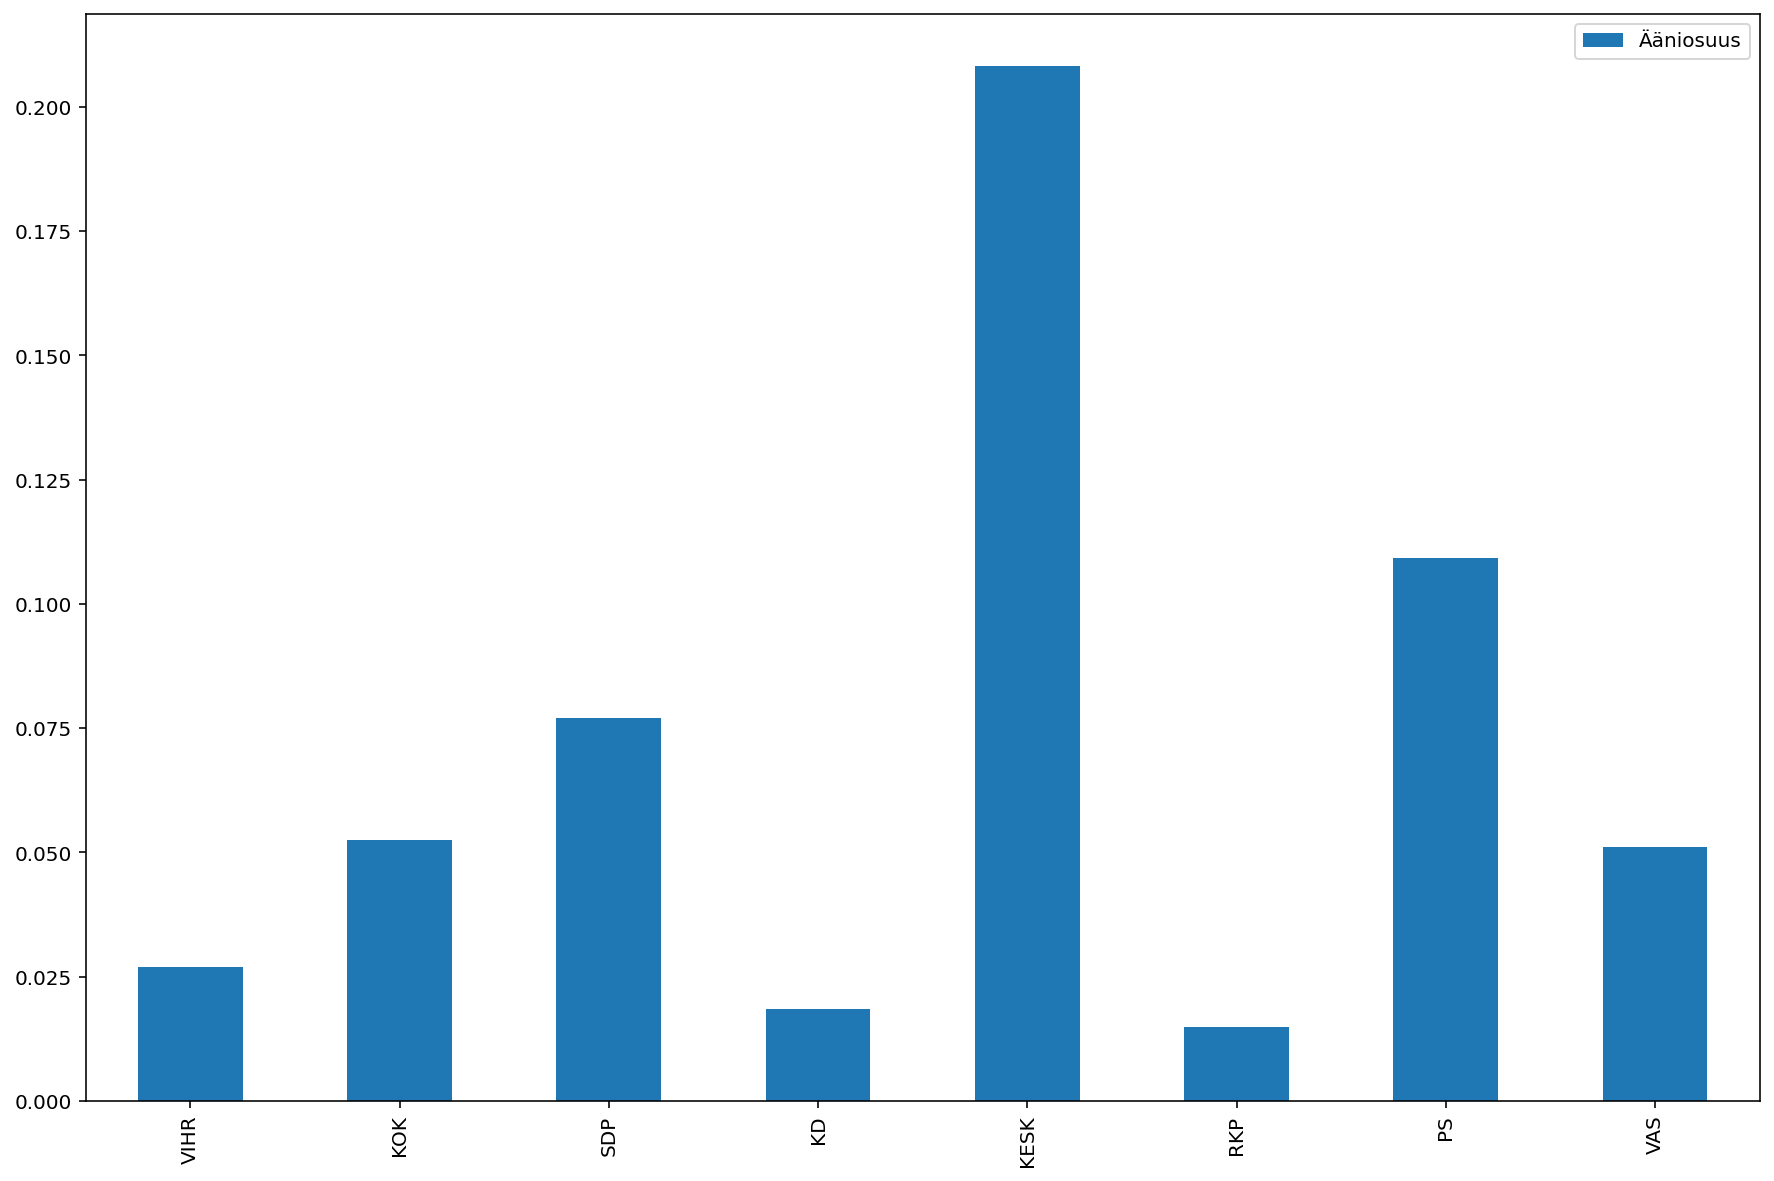

In [19]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [20]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2381       81460     KÄENKOSKI        Ilomantsi                          26.0   
2349       82880   MANNERVAARA          Joensuu                          18.0   
2094       71690     VARPASMAA           Kuopio                          13.0   
792        25960       HÖGSÅRA      Kemiönsaari                          45.0   
2228       88690     MAANSELKÄ          Sotkamo                          45.0   

     Suurin_puolue  \
2381          KESK   
2349          KESK   
2094          KESK   
792            RKP   
2228          KESK   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2381                                                          0.0   
2349                                                          0.0   
2094                                                          0.0   
792                                                           0.0   
2228                                                          0.0   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
2381                                          0.0   
2349                                          0.0   
2094                                          0.0   
792                                           0.0   
2228                                          0.0   

      Teini-ikäisten lasten taloudet, 2018 (TE) osuudesta taloudet  \
2381                                                           0.0   
2349                                                           0.0   
2094                                                           0.0   
792                                                            0.0   
2228                                                           0.0   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2381                                                              0.0   
2349                                                              0.0   
2094                                                              0.0   
792                                                               0.0   
2228                                                              0.0   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2381                                                              0.0   
2349                                                              0.0   
2094                                                              0.0   
792                                                               0.0   
2228                                                              0.0   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2381                                                                    0.0   
2349                                                                    0.0   
2094                                                                    0.0   
792                                                                     0.0   
2228                                                                    0.0   

      Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  
2381                                                                         0.0  
2349                                                                         0.0  
2094                                                                         0.0  
792                                                                          0.0  
2228                                                                         0.0

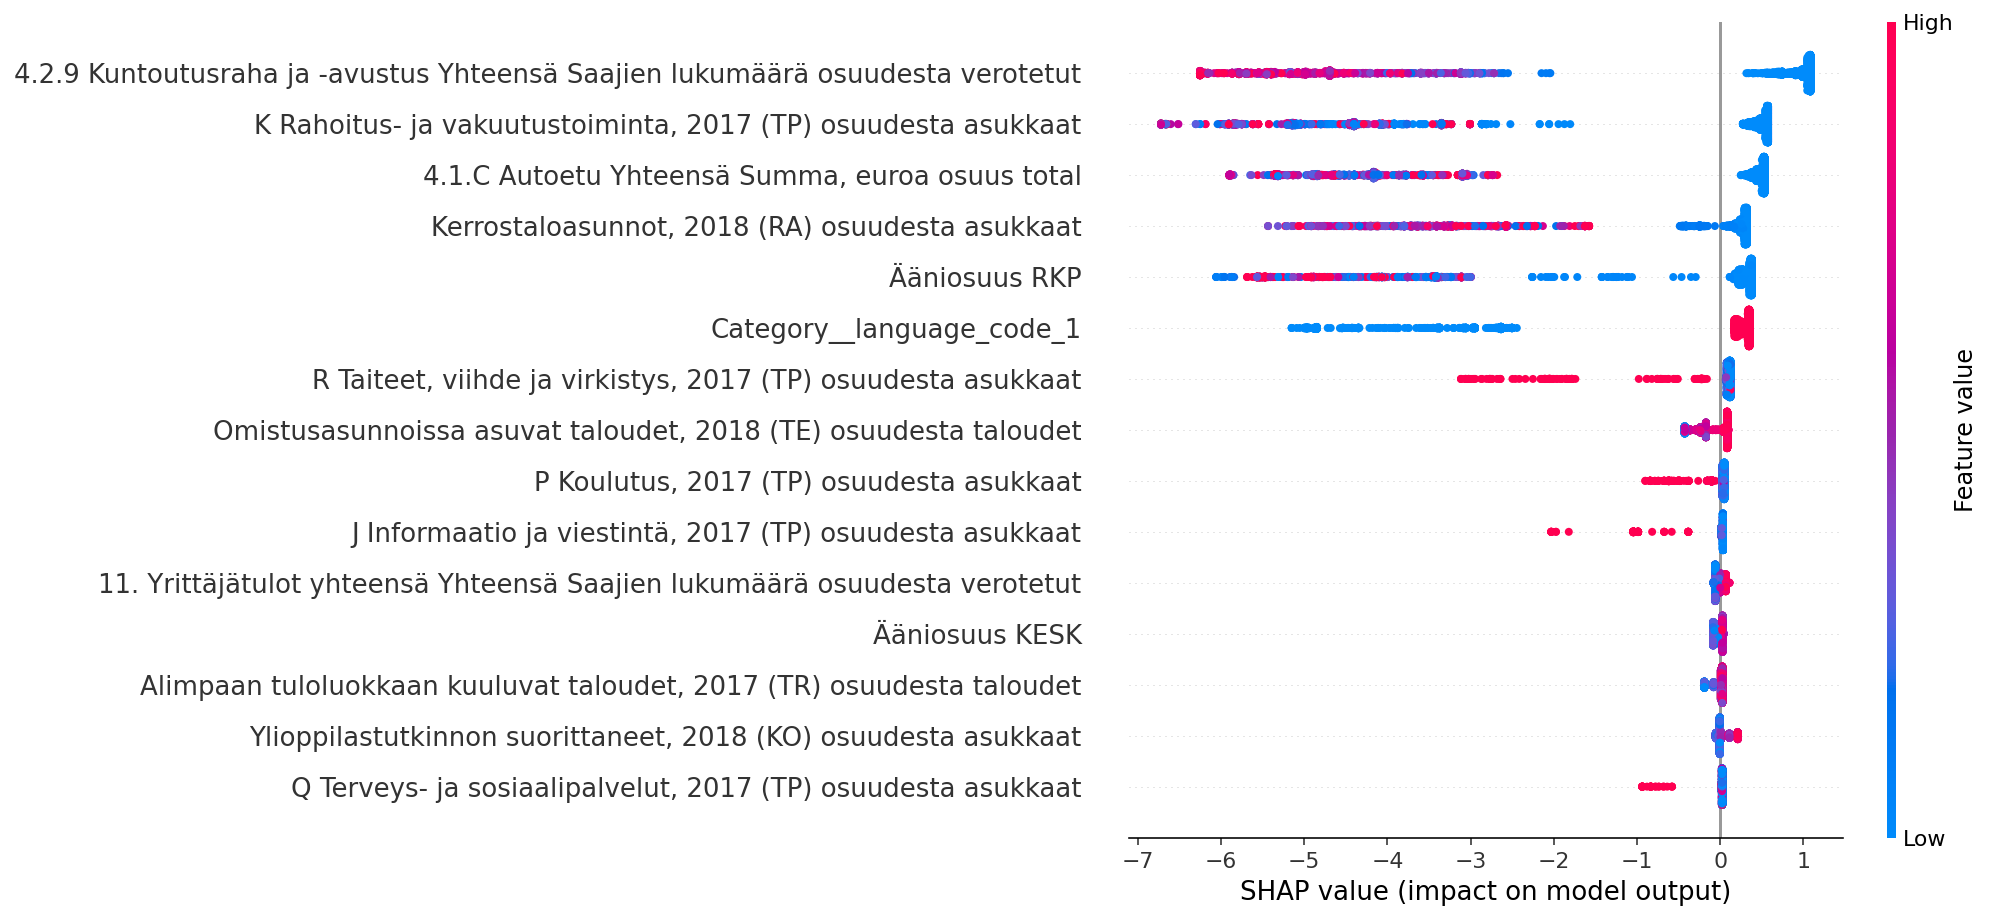

In [21]:
shap_index = 2
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


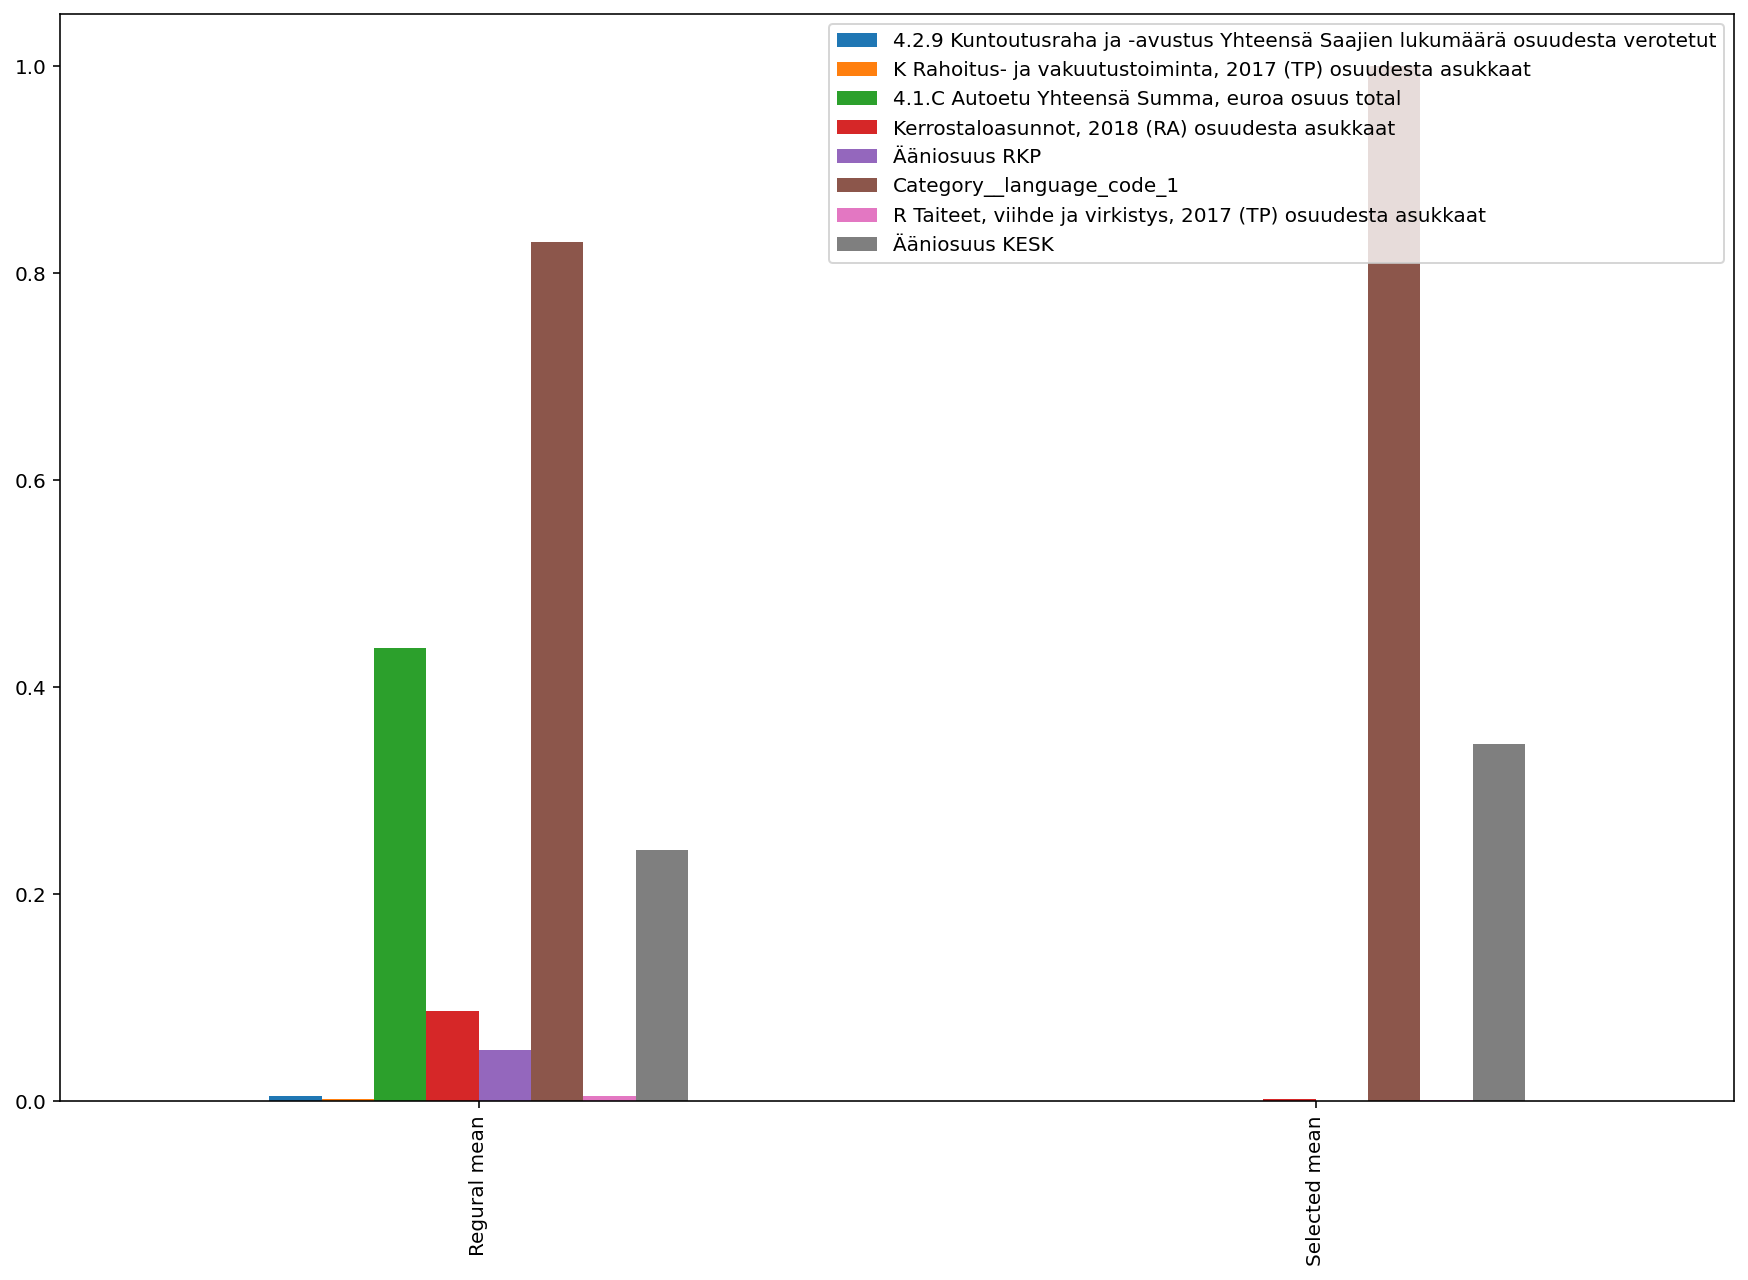

In [22]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

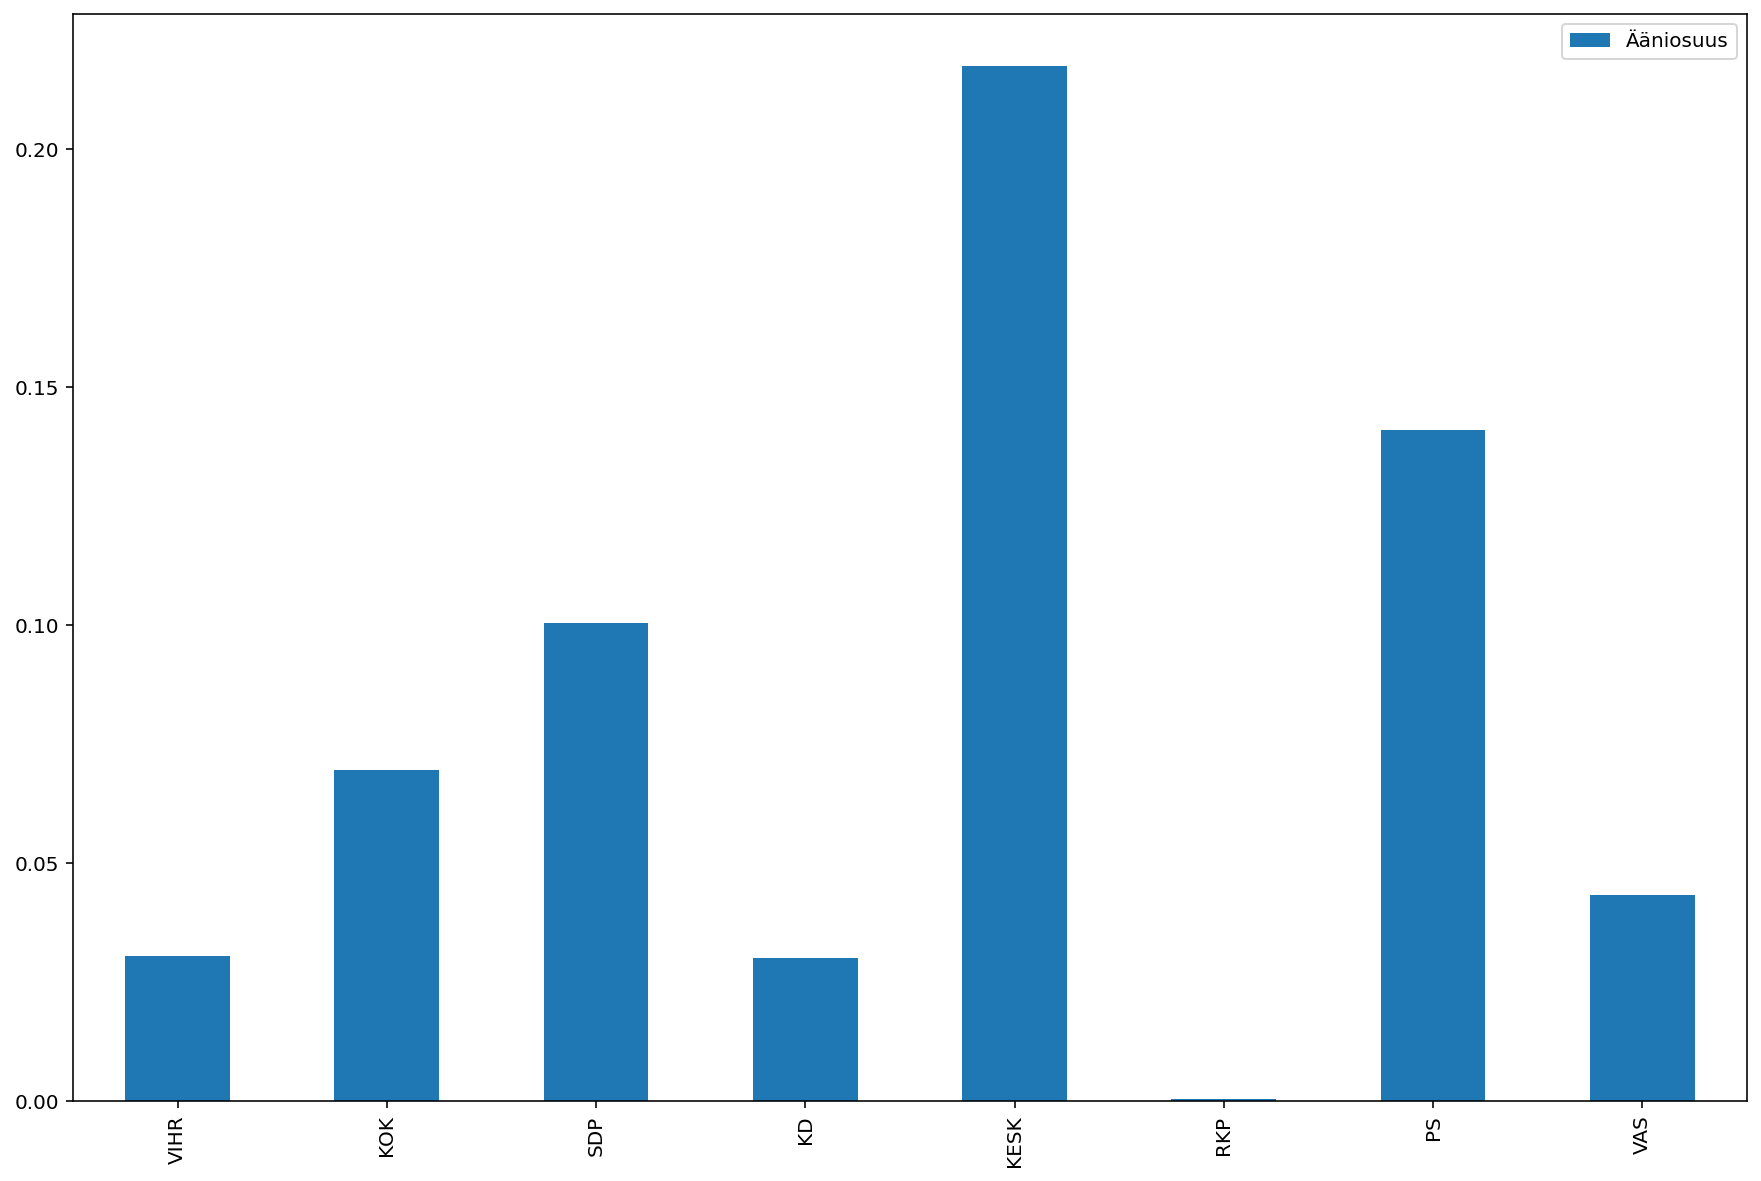

In [23]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [24]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2741       95270     YLIKÄRPPÄ             Simo                          91.0   
2946       98830        MARTTI        Savukoski                         148.0   
2744       95330       TERVOLA          Tervola                         500.0   
1792       62160    KARHUNKYLÄ            Lapua                         590.0   
1091       35630     KUOREVESI            Jämsä                         161.0   

     Suurin_puolue  Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2741          KESK                                         0.032967   
2946          KESK                                         0.000000   
2744          KESK                                         0.006000   
1792          KESK                                         0.000000   
1091           SDP                                         0.000000   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2741                                                            0.0   
2946                                                            0.0   
2744                                                            0.0   
1792                                                            0.0   
1091                                                            0.0   

      R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta asukkaat  \
2741                                                      0.000000   
2946                                                      0.000000   
2744                                                      0.000000   
1792                                                      0.001695   
1091                                                      0.000000   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2741                                                                             0.0   
2946                                                                             0.0   
2744                                                                             0.0   
1792                                                                             0.0   
1091                                                                             0.0   

      4.1.C Autoetu Yhteensä Summa, euroa osuus total  Ääniosuus RKP  \
2741                                              0.0            0.0   
2946                                              0.0            0.0   
2744                                              0.0            0.0   
1792                                              0.0            0.0   
1091                                              0.0            0.0   

      Category__language_code_1  
2741                          1  
2946                          1  
2744                          1  
1792                          1  
1091                          1

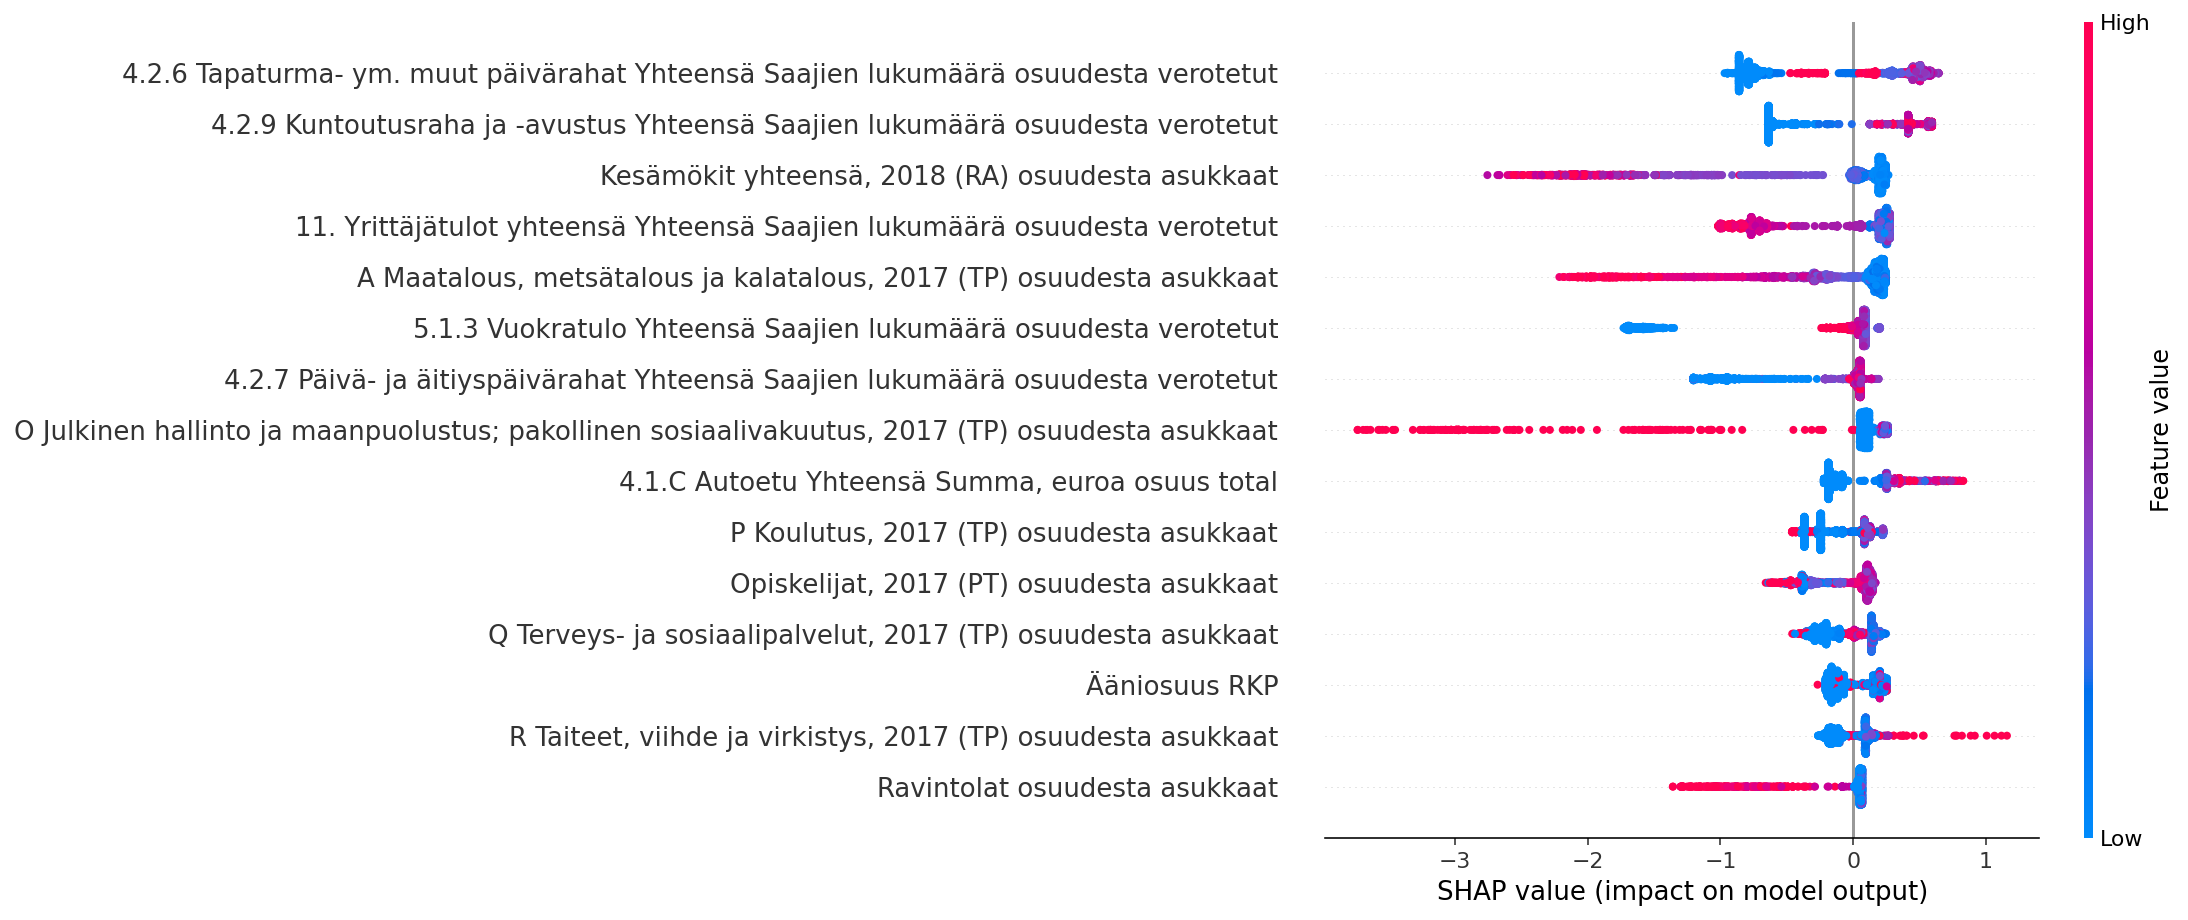

In [25]:
shap_index = 3
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


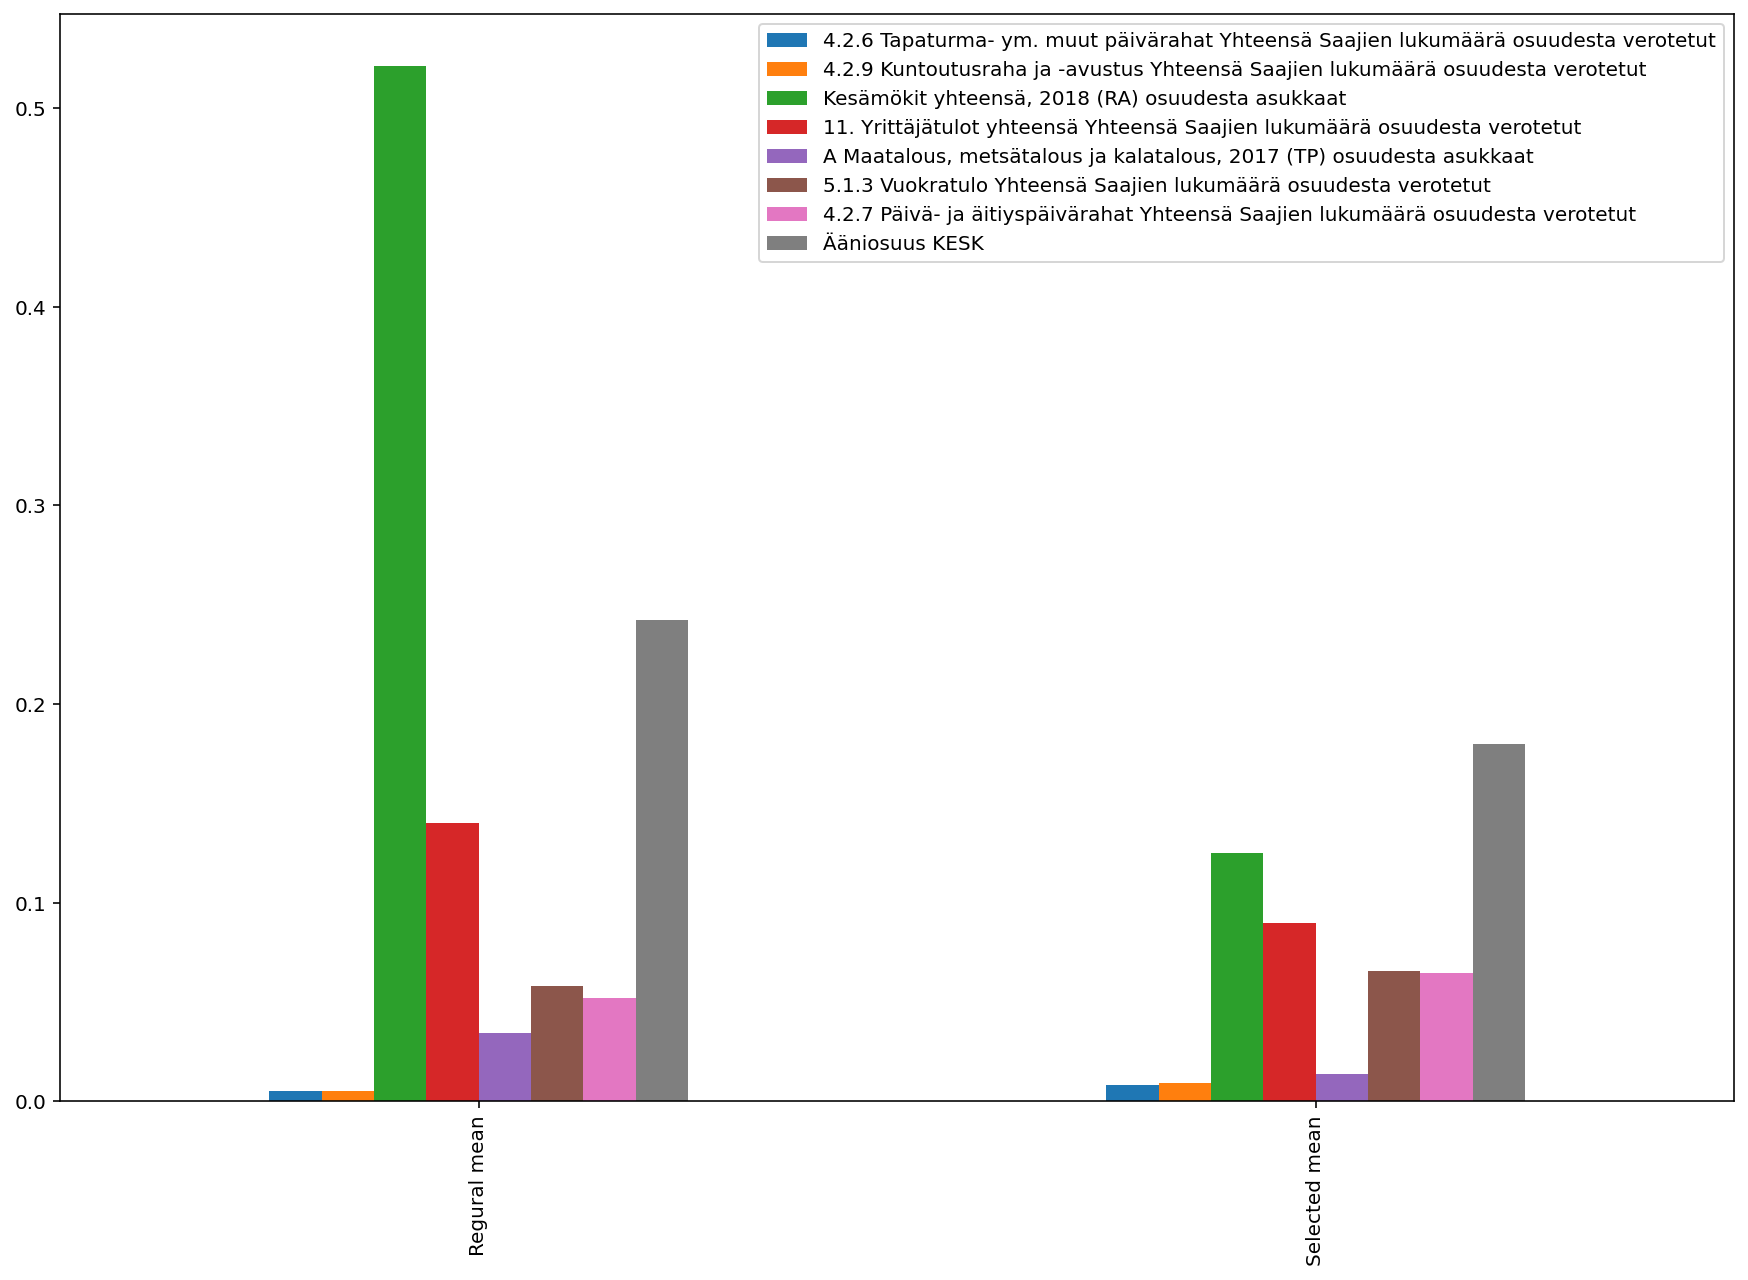

In [26]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

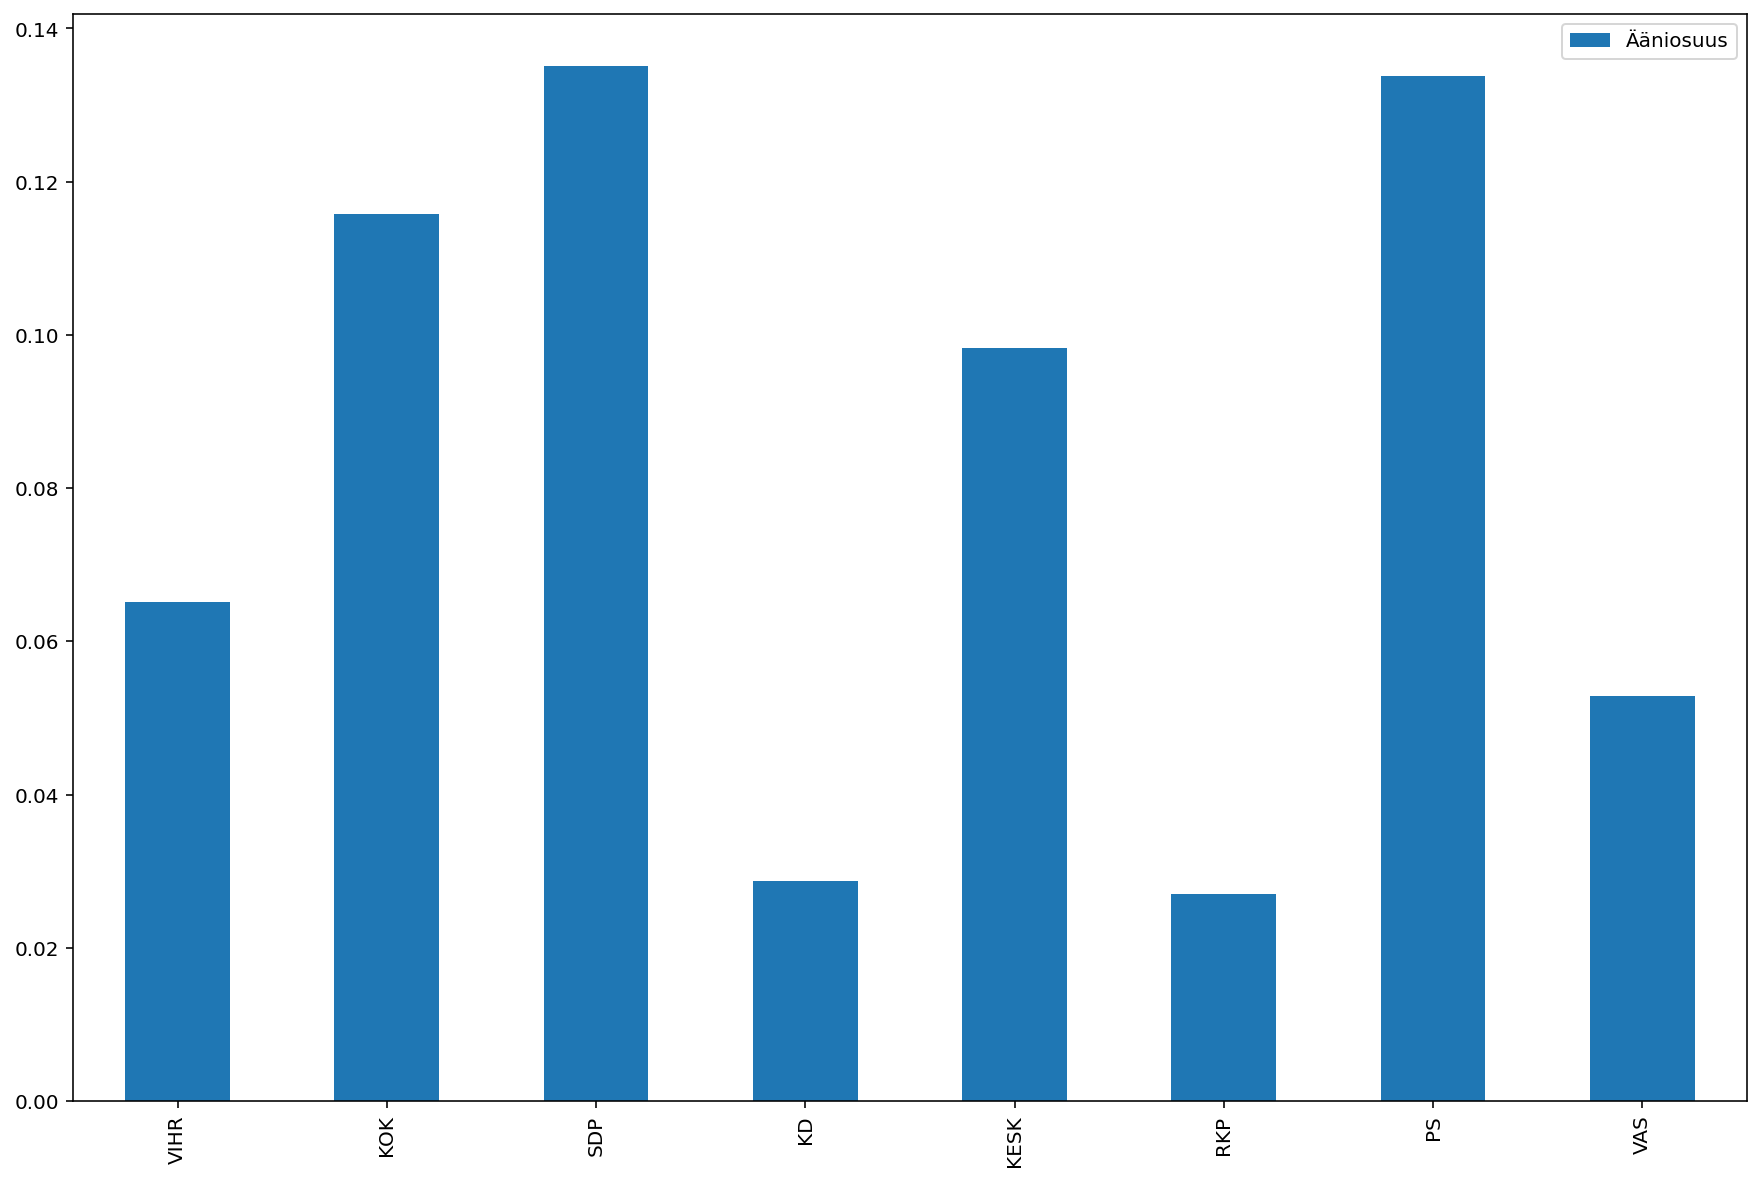

In [27]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [28]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2067       70420        KUOPIO           Kuopio                        2297.0   
1771       66440     TERVAJOKI          Isokyrö                        1921.0   
1655       59800     KESÄLAHTI            Kitee                        1494.0   
1055       33920      PIRKKALA         Pirkkala                        1250.0   
89         01200        VANTAA           Vantaa                       12195.0   

     Suurin_puolue  Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
2067           KOK                                          0.151067   
1771            PS                                          0.046851   
1655          KESK                                          0.419009   
1055           SDP                                          0.000800   
89             SDP                                          0.001394   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
2067                                                              0.001306   
1771                                                              0.018740   
1655                                                              0.034137   
1055                                                              0.000000   
89                                                                0.000574   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
2067                                                                   0.057234   
1771                                                                   0.140023   
1655                                                                   0.136364   
1055                                                                   0.048504   
89                                                                     0.029326   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2067                                                                             0.005829   
1771                                                                             0.011669   
1655                                                                             0.005772   
1055                                                                             0.005160   
89                                                                               0.006098   

      4.2.7 Päivä- ja äitiyspäivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2067                                                                         0.071012   
1771                                                                         0.079347   
1655                                                                         0.048341   
1055                                                                         0.053664   
89                                                                           0.061943   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2067                                                                        0.014308   
1771                                                                        0.008168   
1655                                                                        0.011544   
1055                                                                        0.006192   
89                                                                          0.009775   

      5.1.3 Vuokratulo Yhteensä Saajien lukumäärä osuudesta verotetut  
2067                                                         0.067833  
1771                                                         0.044341  
1655                                                         0.067821  
1055                                                         0.098039  
89                                                           0.022455

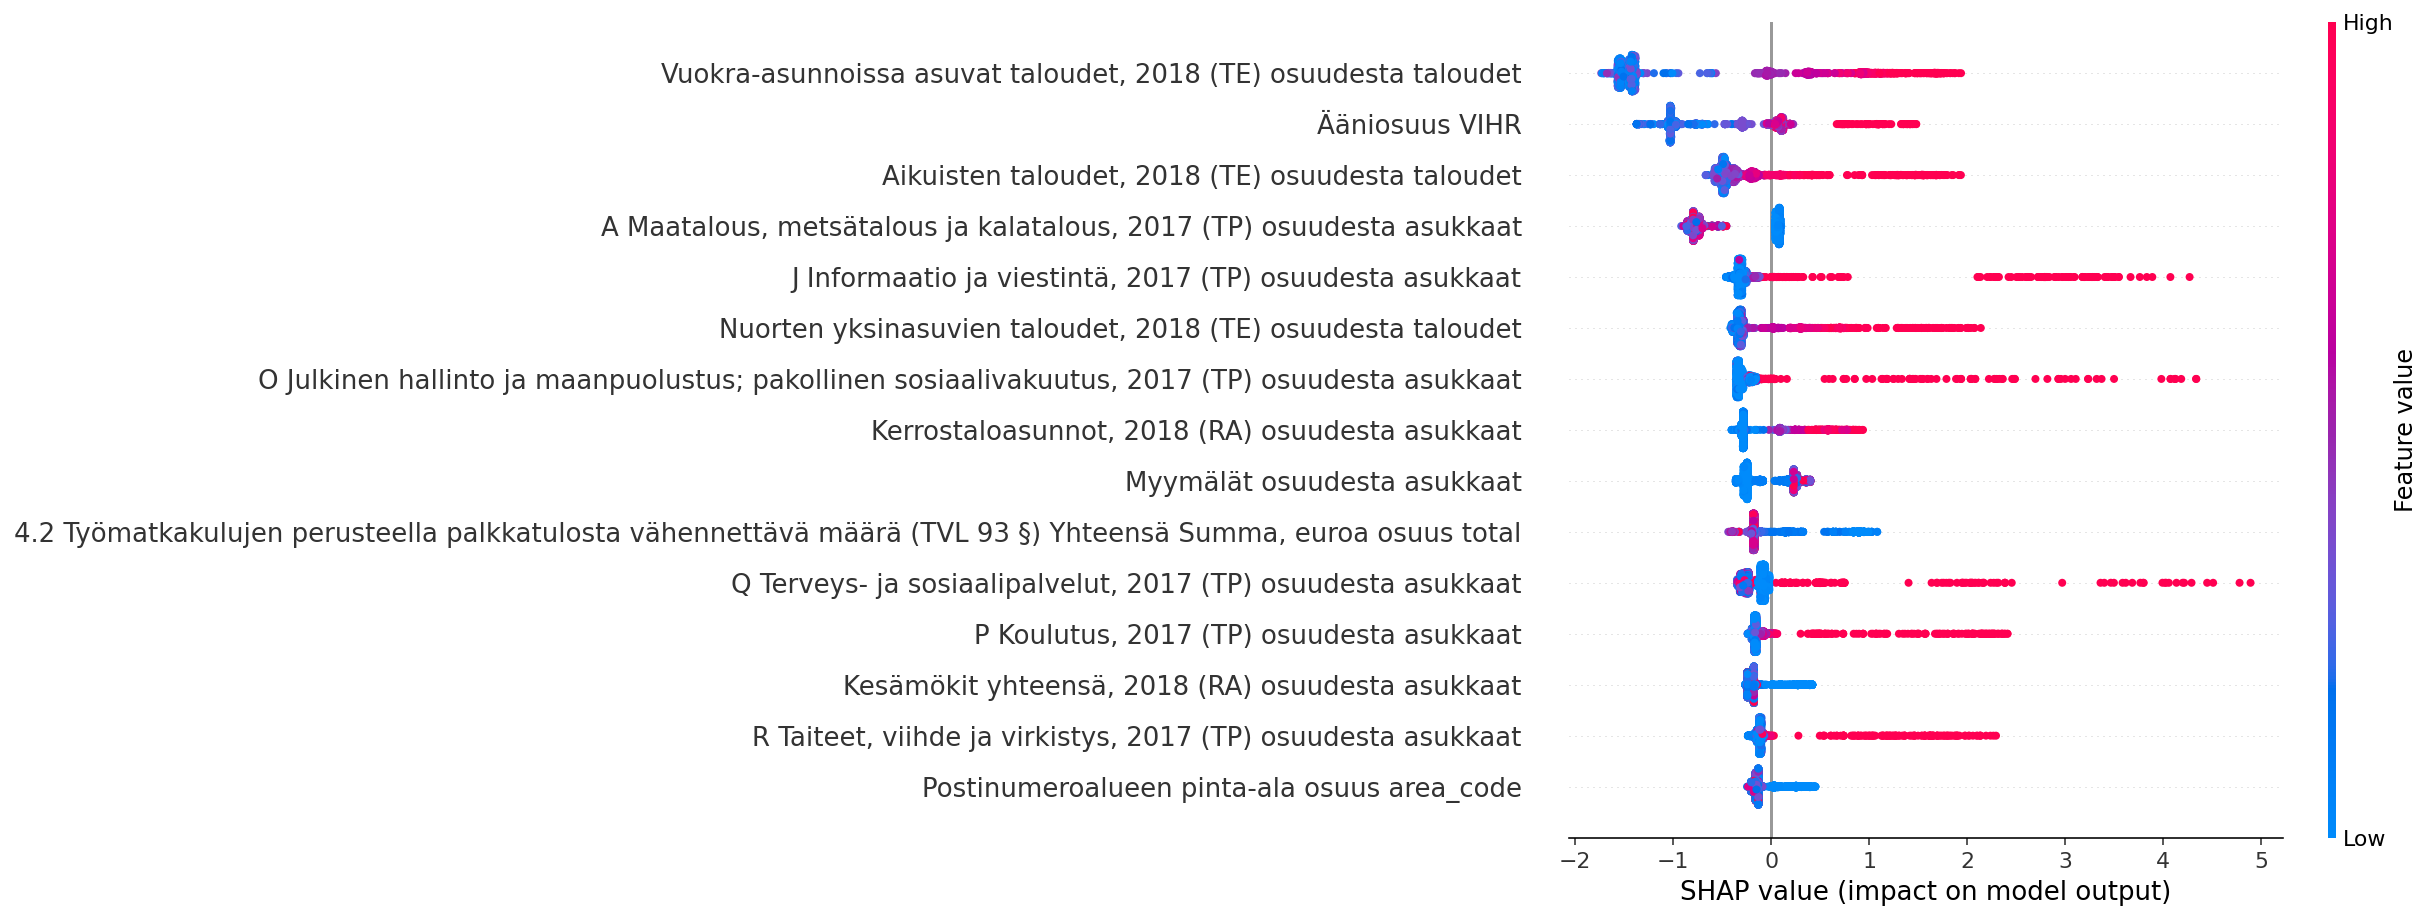

In [29]:
shap_index = 4
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'max')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


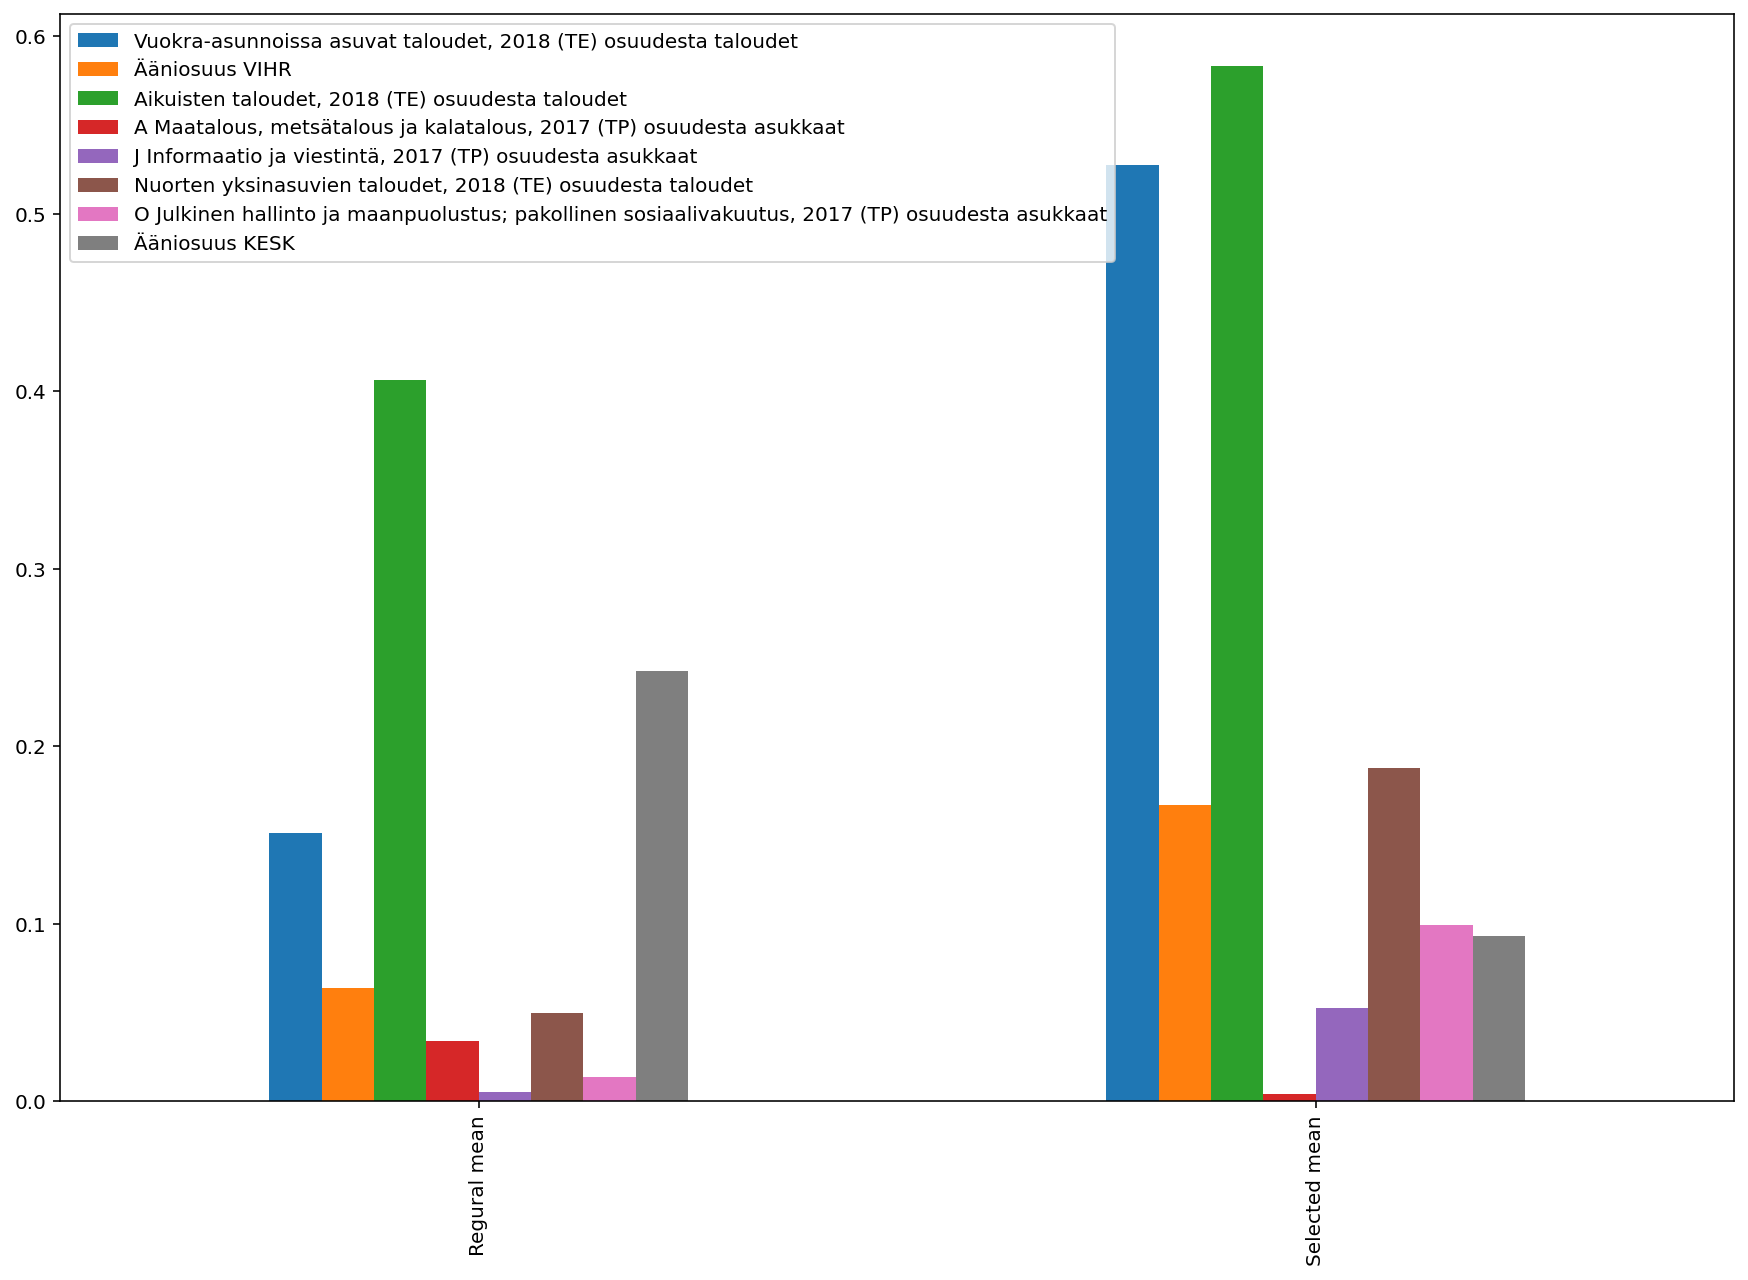

In [30]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

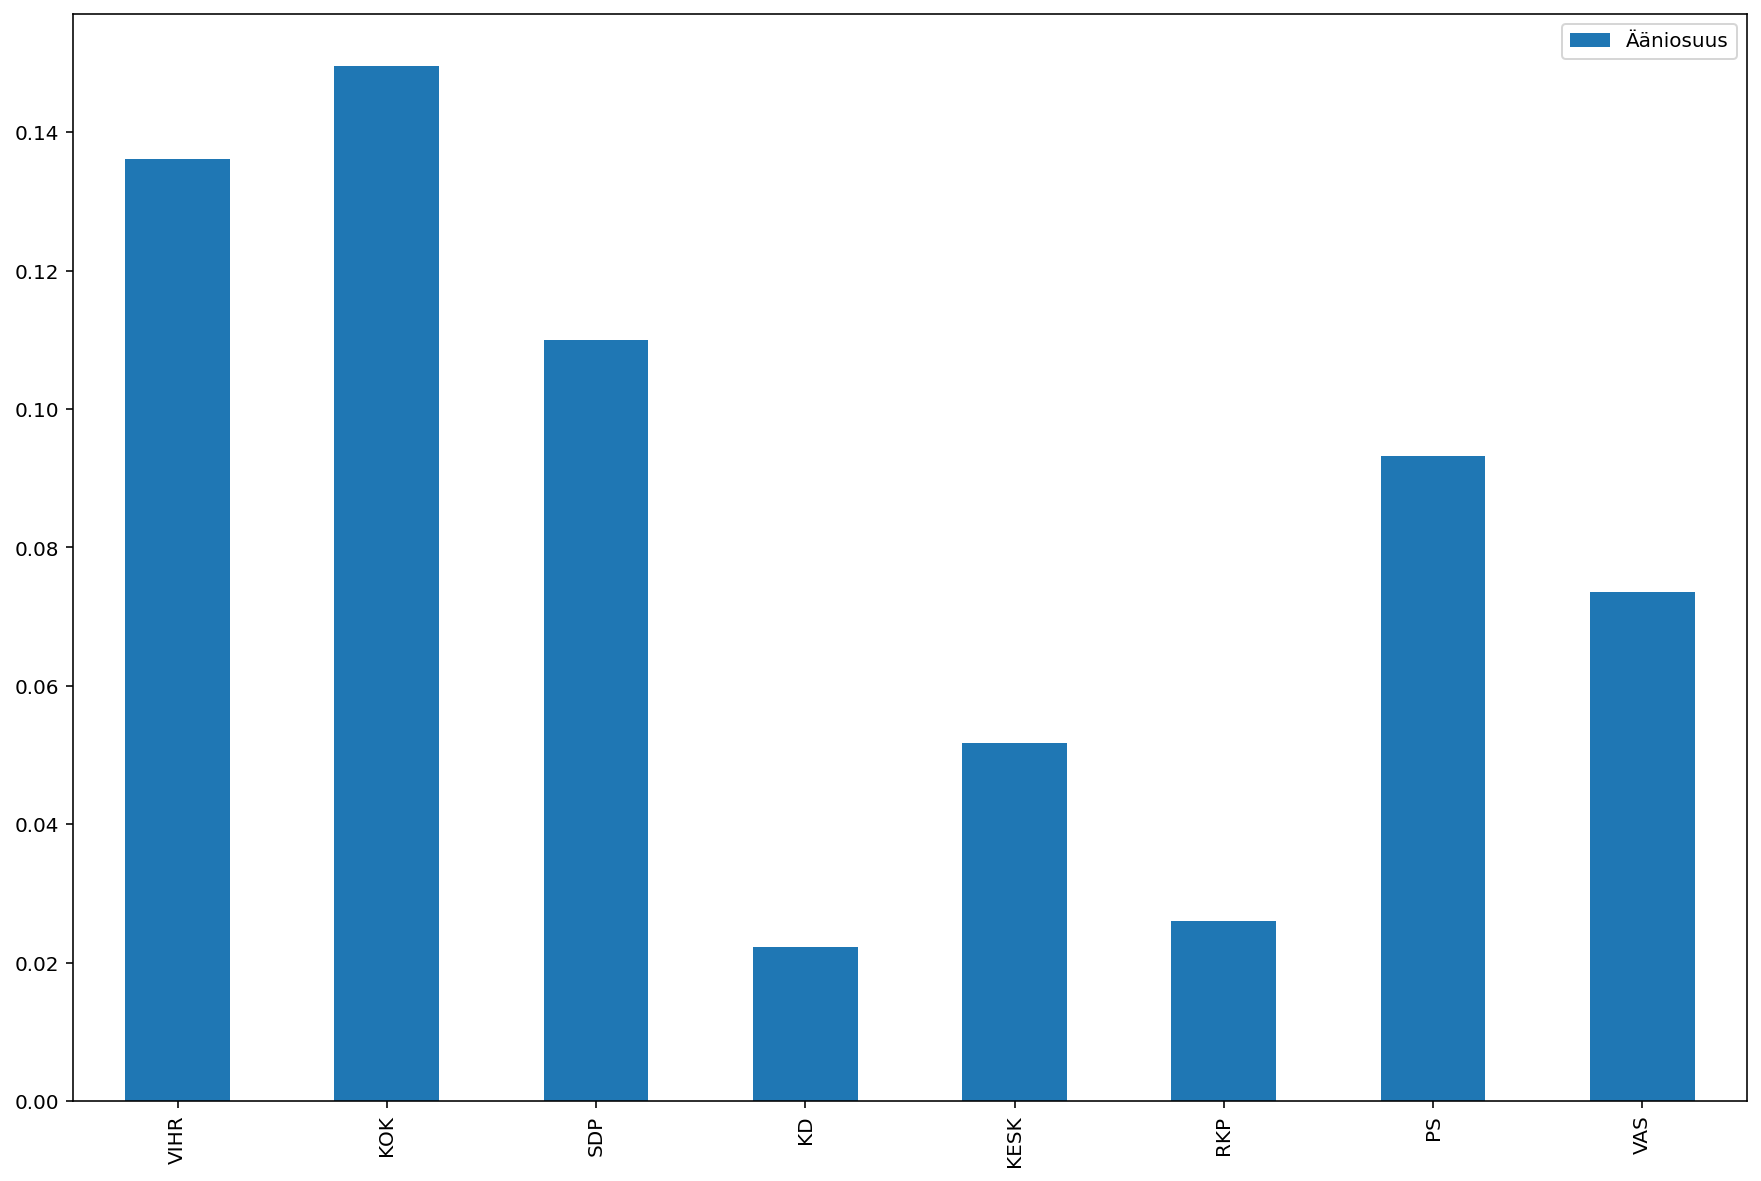

In [31]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [32]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2514       87100       KAJAANI          Kajaani                        5928.0   
2600       90510          OULU             Oulu                        1842.0   
1542       53100  LAPPEENRANTA     Lappeenranta                       10498.0   
392        13100   HÄMEENLINNA      Hämeenlinna                       11271.0   
34         00520      HELSINKI         Helsinki                        7276.0   

     Suurin_puolue  \
2514          KESK   
2600           VAS   
1542           KOK   
392            KOK   
34            VIHR   

      A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat  \
2514                                                              0.009109   
2600                                                              0.001629   
1542                                                              0.001905   
392                                                               0.002396   
34                                                                0.000687   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
2514                                                  0.056511   
2600                                                  0.003257   
1542                                                  0.035054   
392                                                   0.029456   
34                                                    0.279137   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
2514                                                                                         0.139001   
2600                                                                                         0.000000   
1542                                                                                         0.081635   
392                                                                                          0.122083   
34                                                                                           0.491616   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2514                                                     0.249938   
2600                                                     0.225711   
1542                                                     0.184842   
392                                                      0.202035   
34                                                       0.160670   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
2514                                          0.555306   
2600                                          0.665358   
1542                                          0.502314   
392                                           0.516120   
34                                            0.644928   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2514                                                         0.525593   
2600                                                         0.493621   
1542                                                         0.458345   
392                                                          0.444333   
34                                                           0.523738   

      Ääniosuus VIHR  
2514        0.109262  
2600        0.154601  
1542        0.159722  
392         0.126700  
34          0.285624

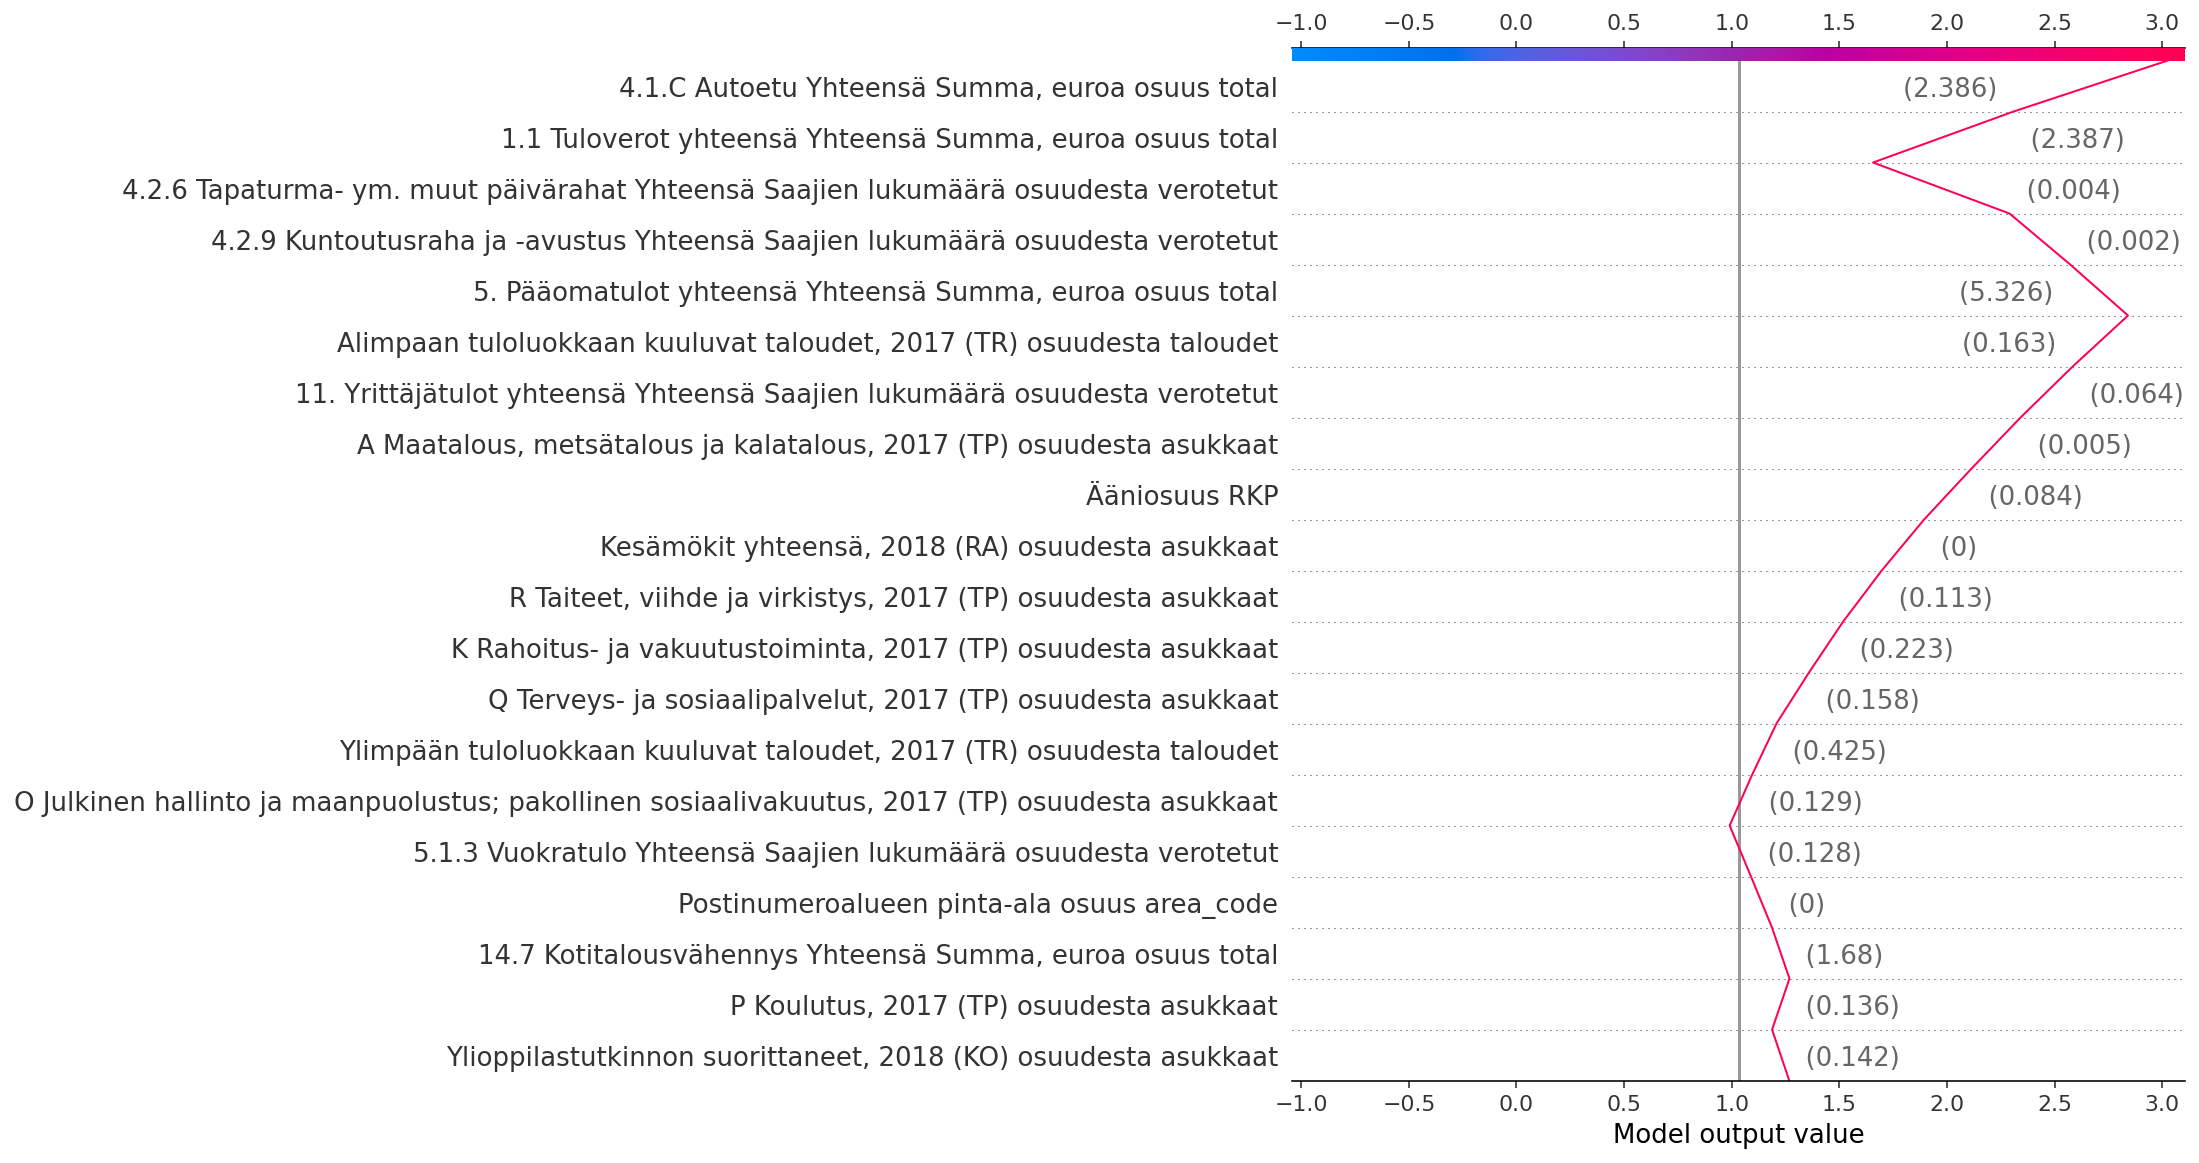

In [34]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
shap_index = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[shap_index], shap_values[shap_index][idx], X)


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


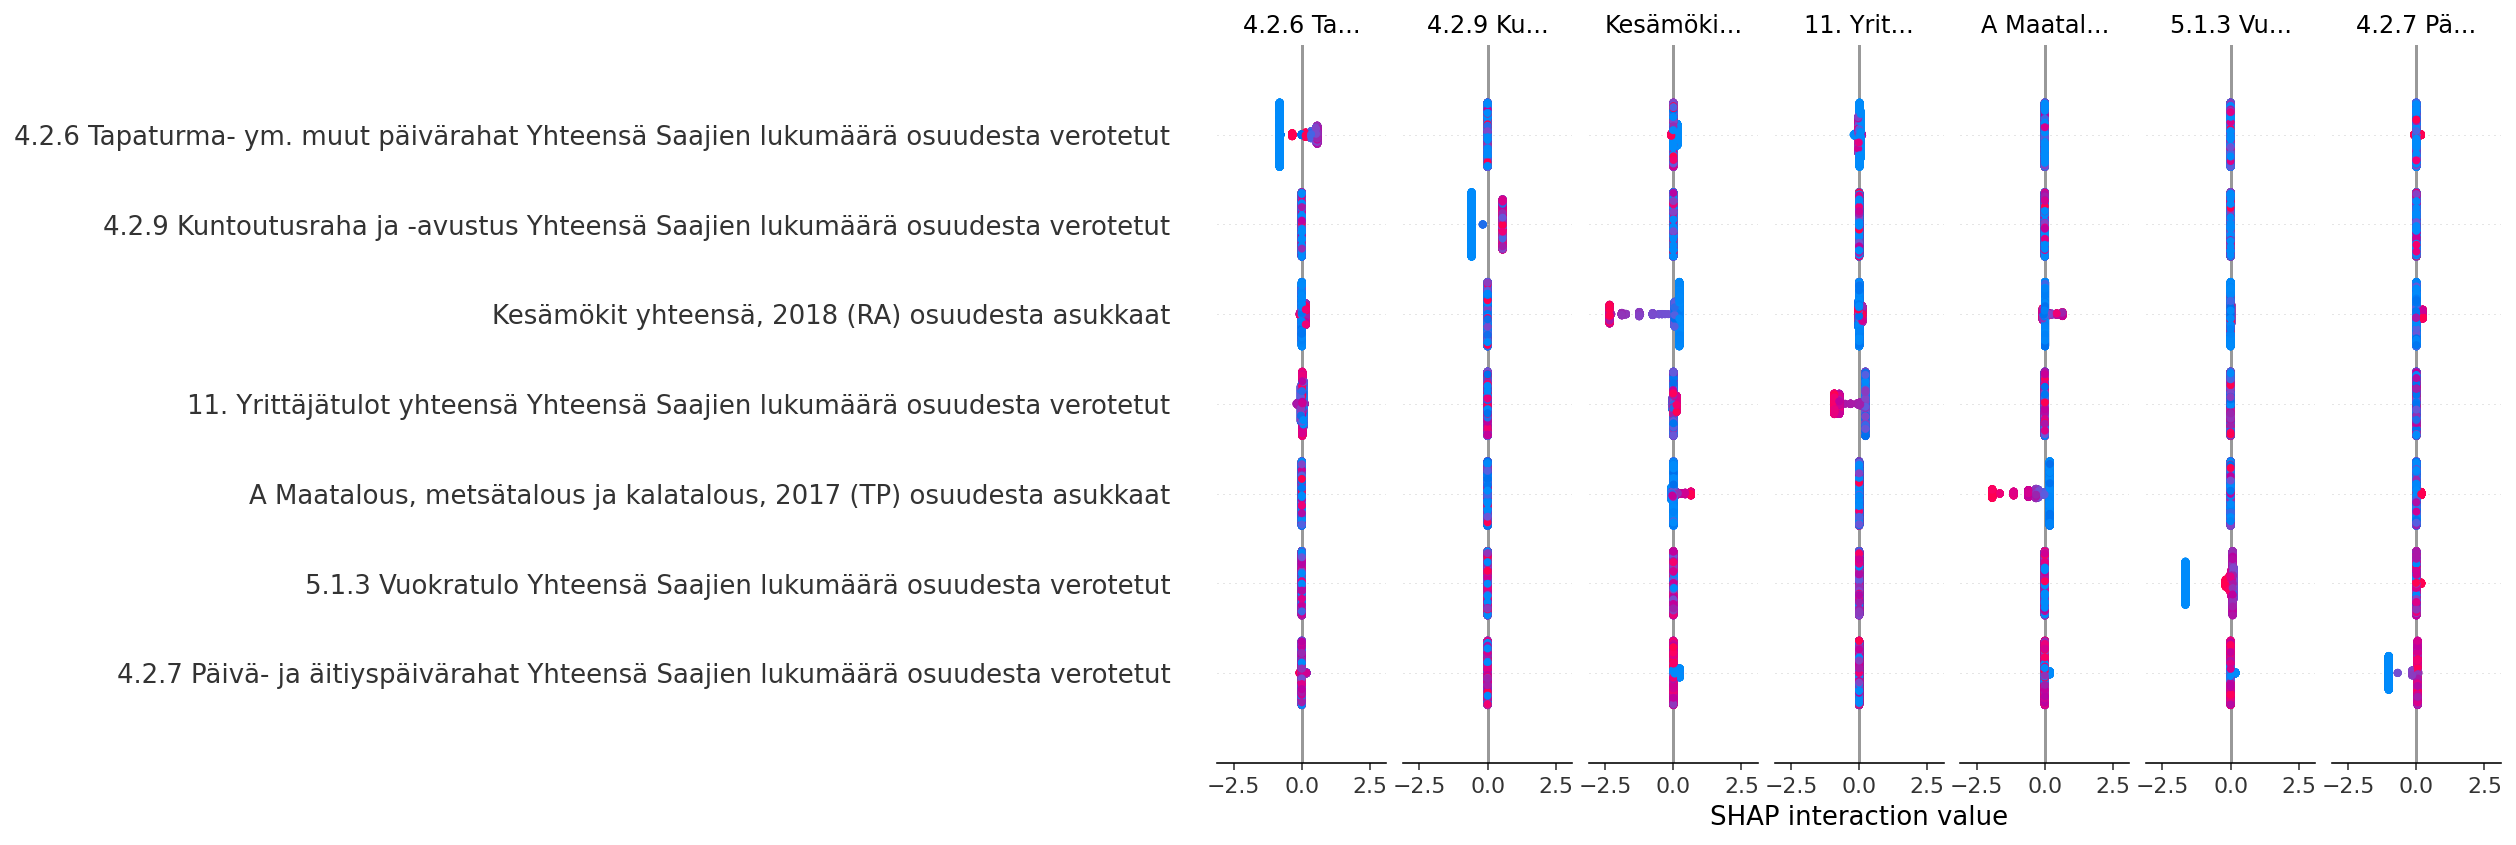

In [35]:
shap.summary_plot(shap_interaction_values[shap_index], X)